In [99]:
# Âá∫Ëµ∞È¶¨„Å´„Å§„ÅÑ„Å¶‰∏ä‰Ωç„Å´ÂÖ•„ÇãÁ¢∫Áéá„Çí‰∫àÊÉ≥„Åó„ÄÅÁ¢∫Áéá„ÅåÈñæÂÄ§‰ª•‰∏ä„ÅÆÂ†¥Âêà„Å´Èôê„ÇäË≥ºÂÖ•„Åô„Çã„Åì„Å®„ÇíËÄÉ„Åà„Çã
# ÈñæÂÄ§„Çí‰Ωø„Çè„Åö„Å´Ë≥ºÂÖ•„Åó„ÅüÂ†¥Âêà„Å®ÈñæÂÄ§‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÅßÊØîËºÉ„Åó„ÄÅÁöÑ‰∏≠Áéá„ÇÑÂõûÂèéÁéá„ÅåÊîπÂñÑ„Åï„Çå„Çã„ÅãÁ¢∫Ë™ç„Åô„Çã

In [1]:
# „Ç§„É≥„Éù„Éº„Éà
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# ! pip install japanize-matplotlib
import japanize_matplotlib
from scipy import stats

In [3]:
# CSV„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
# df = pd.read_csv('input_Á∑®ÈõÜÂæå.csv', encoding='utf-8')
num_horses = 9
df = pd.read_csv(f'input_{num_horses}È†≠_Á∑®ÈõÜÂæå.csv', encoding='utf-8')
df['race_date'] = pd.to_datetime(df['race_date'])  # Êó•‰ªò„ÅåÊñáÂ≠óÂàó„Å™„ÇâÂ§âÊèõ
print(f"df„ÅÆË°åÊï∞„ÅØ {len(df)} ")
# „É¨„Éº„ÇπID„ÄÅÈ¶¨Áï™È†Ü„Å´‰∏¶„Å≥Êõø„Åà
df = df.sort_values(by=['race_id', 'horse_number'])

df„ÅÆË°åÊï∞„ÅØ 78768 


In [5]:

def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):

    """
    ÂõûÂèéÁéá„ÅÆ‰ø°È†ºÂå∫Èñì„ÇíÊ±Ç„ÇÅ„ÇãÈñ¢Êï∞

    Parameters
    ----------
    mean       : float           Âπ≥ÂùáÂõûÂèéÁéáÔºà‰æãÔºö1.05Ôºâ
    std        : float           Ê®ôÊ∫ñÂÅèÂ∑Æ  Ôºà‰æãÔºö0.15Ôºâ
    n          : int             „Çµ„É≥„Éó„É´Êï∞Ôºà„É¨„Éº„ÇπÊï∞Ôºâ
    confidence : float, optional ‰ø°È†ºÊ∞¥Ê∫ñÔºà„Éá„Éï„Ç©„É´„Éà„ÅØ0.95Ôºâ

    Returns
    -------
    (lower, upper) : tuple of float
        ‰ø°È†ºÂå∫Èñì„ÅÆ‰∏ãÈôêÂÄ§„Å®‰∏äÈôêÂÄ§
    """
    
    # tÂÄ§ÔºàtÂàÜÂ∏É„ÅÆËá®ÁïåÂÄ§Ôºâ
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    
    # ‰ø°È†ºÂå∫Èñì„ÅÆÂπÖÔºà„Éû„Éº„Ç∏„É≥Ôºâ
    margin = t_value * std / np.sqrt(n)
    
    # Âå∫Èñì„ÅÆ‰∏ãÈôê„Éª‰∏äÈôê
    lower = mean - margin
    upper = mean + margin
    
    return lower, upper
    

In [7]:
# === Ê¨†ÊêçÂÄ§ÂØæÂøú„ÅÆË®≠ÂÆö ===
handle_missing = True  # True„ÅßÂØæÂøúON„ÄÅFalse„Åß„Çπ„Ç≠„ÉÉ„Éó
min_non_missing_horses = num_horses  # „Åì„ÅÆÈ†≠Êï∞‰ª•‰∏ä„Åß„ÅÇ„Çå„Å∞Ë£úÂÆå„ÄÅ„Åù„ÇåÊú™Ê∫Ä„Å™„Çâ„É¨„Éº„Çπ„Åî„Å®Èô§Â§ñ

# Ê¨†ÊêçÂá¶ÁêÜÂØæË±°„ÅÆÁâπÂæ¥Èáè„ÇíÊåáÂÆöÔºàÂøÖË¶Å„Å´Âøú„Åò„Å¶Êã°ÂºµÔºâ
missing_check_features = [
    'time_index_average_2',
    'jockey_place_rate_100'
]

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("‚ö† Ê¨†ÊêçÂá¶ÁêÜ„ÅØ„Çπ„Ç≠„ÉÉ„Éó„Åï„Çå„Åæ„Åó„Åü„ÄÇ")
        return df

    print("‚úÖ Ê¨†ÊêçÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô...")
    valid_race_ids = []
    processed_groups = []

    for race_id, group in df.groupby('race_id'):
        # Ê¨†Êêç„Åå„Å™„ÅÑË°åÊï∞„Çí„Ç´„Ç¶„É≥„Éà
        non_missing_mask = group[features].notnull().all(axis=1)
        non_missing_count = non_missing_mask.sum()

        if non_missing_count < min_horses:
            # ‚Üí ÊåáÂÆöÈ†≠Êï∞Êú™Ê∫Ä ‚Üí Èô§Â§ñ
            continue
        else:
            # ‚Üí ÊåáÂÆöÈ†≠Êï∞‰ª•‰∏ä ‚Üí Âπ≥ÂùáÂÄ§„ÅßË£úÂÆå
            for col in features:
                if group[col].isnull().any():
                    mean_val = group[col].mean(skipna=True)
                    group[col] = group[col].fillna(mean_val)
            processed_groups.append(group)

    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"‚úÖ Ê¨†ÊêçÂá¶ÁêÜÂæå„ÅÆ„É¨„Ç≥„Éº„ÉâÊï∞: {len(df_processed)}ÔºàÂÖÉ: {len(df)}Ôºâ")
    return df_processed

# === Ê¨†ÊêçÂá¶ÁêÜ„ÅÆÂÆüË°å ===
df_not_handle_missing_val = df.copy()
df_handle_missing_val = handle_missing_val(
    df_not_handle_missing_val,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)


‚úÖ Ê¨†ÊêçÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô...
‚úÖ Ê¨†ÊêçÂá¶ÁêÜÂæå„ÅÆ„É¨„Ç≥„Éº„ÉâÊï∞: 46701ÔºàÂÖÉ: 78768Ôºâ


In [9]:
# ---------- Ë™¨ÊòéÂ§âÊï∞ ----------------------------
df_feature = df_handle_missing_val.copy()
race_avg_time_index = df_feature.groupby('race_id')['time_index_average_2'].transform('mean')
df_feature['time_index_diff_from_avg'] = df_feature['time_index_average_2'] - race_avg_time_index
race_avg_jockey_place_rate = df_feature.groupby('race_id')['jockey_place_rate_100'].transform('mean')
df_feature['jockey_place_rate_diff_from_avg'] = df_feature['jockey_place_rate_100'] - race_avg_jockey_place_rate
features = [
    'time_index_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- „É™„Éº„ÇØÈò≤Ê≠¢„ÅÆ„É©„Éô„É´‰∏ÄÊã¨‰ΩúÊàê ----------
# ‰∏ä‰Ωç4È†≠ ‚Üí is_top4
df_feature['is_top4'] = (
    df_feature.groupby('race_id')['finish_rank']
    .rank(method='first') <= num_horses / 2 
).astype(int)

df_feature.to_csv('C:\\Users\\ryo\\Downloads\\df_feature.csv', index=False, encoding='cp932')

In [11]:
# „Éï„Ç£„É´„ÇøÊù°‰ª∂„ÇíÈÅ©Áî®
filtered_df = df_feature.copy()
## Âπ¥
train_year = 2023
valid_year = 2024
if train_year < valid_year:
    min_year = train_year
    max_year = valid_year
else:
    min_year = valid_year
    max_year = train_year
filtered_df = filtered_df[
    (filtered_df['race_date'].dt.year >= min_year) &
    (filtered_df['race_date'].dt.year <= max_year)
]
## ‰∫∫Ê∞ó
# filtered_df = filtered_df[filtered_df['popularity'] == 2]

# „Ç´„Ç¶„É≥„Éà
print(f"filtered_df„ÅÆË°åÊï∞„ÅØ {len(filtered_df)} ")

filtered_df„ÅÆË°åÊï∞„ÅØ 20403 


In [13]:
# ---------- „É¢„Éá„É´1 ----------
df_m1 = filtered_df.copy()

# ---------- ÂêÑ„É¢„Éá„É´„ÅÆÁâπÂæ¥Èáè„Å®ÁõÆÁöÑÂ§âÊï∞ ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- „É¢„Éá„É´1„ÅÆÂ≠¶Áøí ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == train_year]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == train_year]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == valid_year]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == valid_year]

print(len(X_train_m1), len(y_train_m1), len(X_val_m1), len(y_val_m1))

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    base_score = 0.5,
    max_depth=1,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ‚úÖ Êé®Ë´ñ„Éï„Çß„Éº„Ç∫Ôºà„É¨„Éº„ÇπÂçò‰Ωç„ÅßÈ†Ü„Å´„É¢„Éá„É´„ÇíÈÅ©Áî®„Åó„Å¶1ÁùÄ„Çí‰∫àÊ∏¨Ôºâ
# ============================================================

# ÂØæË±°„Å®„Åô„ÇãÊ§úË®º„Éá„Éº„Çø„ÅÆ„Åø
df_test = filtered_df[filtered_df['race_date'].dt.year == valid_year].copy()

df_test.to_csv('C:\\Users\\ryo\\Downloads\\tmp.csv', index=False, encoding='cp932')

# ÁµêÊûúÊ†ºÁ¥ç„É™„Çπ„Éà
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- „É¢„Éá„É´1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # ‰∏ä‰Ωç4È†≠„ÇíÈÅ∏Âá∫
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    num = int(num_horses / 2)
    group_m1.iloc[:num, group_m1.columns.get_loc('selected_in_m1')] = 1

    # ‚úÖ finish_rank „ÇÇÂê´„ÇÅ„Å¶Âá∫Âäõ
    result_cols = [
        'race_id', 'course_id', 'num_horses', 'race_number', 'weather_name', 'track_condition_name', 'horse_number', 'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features

    full_predictions.append(group_m1[result_cols])

# ÂÖ®„É¨„Éº„ÇπÁµêÂêà
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSVÂá∫Âäõ
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank „ÇíÂê´„ÇÅ„ÅüÂÖ®ÊÆµÈöé„ÅÆ‰∫àÊ∏¨ÁµêÊûúCSV„ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")

### „É¢„Éá„É´„ÅÆË©ï‰æ° ###

# „É¢„Éá„É´1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= num_horses / 2).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# Âá∫Âäõ
print(f"‚ñº „É¢„Éá„É´1Ôºà‰∏ä‰Ωç{int(num_horses / 2)}È†≠‰∫àÊ∏¨Ôºâ„ÅÆÁöÑ‰∏≠Áéá")
print(f"  ‰∫àÊ∏¨Êï∞: {m1_total}, ÁöÑ‰∏≠Êï∞: {m1_hits}, ÁöÑ‰∏≠Áéá: {m1_accuracy:.4f}Ôºà{m1_accuracy:.2%}Ôºâ\n")

# CSVÂá∫Âäõ
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

# ============================
# ‰∫∫Ê∞ó„Åî„Å®„ÅÆ1ÁùÄ‰∫àÊÉ≥ÁöÑ‰∏≠ÁéáÔºÜÂõûÂèéÁéá
# ============================

# ÂêÑ„É¨„Éº„Çπ„Åß pred_prob_m1 „ÅåÊúÄÂ§ß„ÅÆÈ¶¨„Çí1ÁùÄ‰∫àÊÉ≥„Å®„Åó„Å¶ÊäΩÂá∫
df_pred_top1 = full_pred_df.loc[full_pred_df.groupby('race_id')['pred_prob_m1'].idxmax()].copy()

# ÁöÑ‰∏≠„Éï„É©„Ç∞
df_pred_top1['is_hit'] = (df_pred_top1['finish_rank'] == 1).astype(int)

# betÈáëÈ°çÔºà1„É¨„Éº„Çπ„ÅÇ„Åü„ÇäÂõ∫ÂÆöÔºâ„ÇíË®≠ÂÆö
bet_amount = 100
df_pred_top1['payout'] = df_pred_top1['is_hit'] * df_pred_top1['odds'] * bet_amount

# ‰∫∫Ê∞ó„Åî„Å®„Å´ÈõÜË®à
pop_stats = df_pred_top1.groupby('popularity').agg(
    total_pred=('is_hit', 'count'),
    hits=('is_hit', 'sum'),
    total_payout=('payout', 'sum')
).reset_index()

# ÁöÑ‰∏≠Áéá
pop_stats['accuracy'] = pop_stats['hits'] / pop_stats['total_pred']

# ÊäïË≥áÁ∑èÈ°çÔºà1„É¨„Éº„Çπ„ÅÇ„Åü„Çä bet_amountÔºâ
pop_stats['total_bet'] = pop_stats['total_pred'] * bet_amount

# ÂõûÂèéÁéáÔºàROIÔºâ
pop_stats['roi'] = pop_stats['total_payout'] / pop_stats['total_bet']

# Âá∫Âäõ
print("\nüìä ‰∫∫Ê∞ó„Åî„Å®„ÅÆ1ÁùÄ‰∫àÊÉ≥ÁöÑ‰∏≠ÁéáÔºÜÂõûÂèéÁéáÔºàpred_prob_m1ÊúÄÂ§ß„ÅÆÈ¶¨„Çí1ÁùÄ‰∫àÊÉ≥„Å®„Åó„Å¶ÈõÜË®àÔºâ")
print(pop_stats[['popularity', 'total_pred', 'hits', 'accuracy', 'roi']])


10323 10323 10080 10080


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:46:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank „ÇíÂê´„ÇÅ„ÅüÂÖ®ÊÆµÈöé„ÅÆ‰∫àÊ∏¨ÁµêÊûúCSV„ÇíÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ
‚ñº „É¢„Éá„É´1Ôºà‰∏ä‰Ωç4È†≠‰∫àÊ∏¨Ôºâ„ÅÆÁöÑ‰∏≠Áéá
  ‰∫àÊ∏¨Êï∞: 4480, ÁöÑ‰∏≠Êï∞: 2891, ÁöÑ‰∏≠Áéá: 0.6453Ôºà64.53%Ôºâ


üìä ‰∫∫Ê∞ó„Åî„Å®„ÅÆ1ÁùÄ‰∫àÊÉ≥ÁöÑ‰∏≠ÁéáÔºÜÂõûÂèéÁéáÔºàpred_prob_m1ÊúÄÂ§ß„ÅÆÈ¶¨„Çí1ÁùÄ‰∫àÊÉ≥„Å®„Åó„Å¶ÈõÜË®àÔºâ
   popularity  total_pred  hits  accuracy       roi
0         1.0         600   309  0.515000  0.830833
1         2.0         268    57  0.212687  0.690672
2         3.0         126    31  0.246032  1.209524
3         4.0          68     6  0.088235  0.522059
4         5.0          29     5  0.172414  1.796552
5         6.0          21     3  0.142857  1.847619
6         7.0           7     0  0.000000  0.000000
7         8.0           1     0  0.000000  0.000000


In [891]:
# ============================================
# È¶¨Áï™„Åî„Å®„ÅÆ‰∫àÊ∏¨ÁµêÊûú„ÇíÂàÜÊûê
# ============================================

# ÂÆüÈöõ„ÅÆ‰∏ä‰ΩçÔºàfinish_rank <= È†≠Êï∞ / 2Ôºâ„Çí„Éï„É©„Ç∞Âåñ
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# ÈõÜË®àÈñ¢Êï∞„ÇíÂÆöÁæ©
def calc_hit_ratio(group):
    upper = group[group['selected_in_m1'] == 1]
    lower = group[group['selected_in_m1'] == 0]

    upper_hit_rate = upper['is_actual_top'].mean() if len(upper) > 0 else None
    lower_hit_rate = lower['is_actual_top'].mean() if len(lower) > 0 else None

    return pd.Series({
        '‰∏ä‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá': upper_hit_rate,
        '‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá': lower_hit_rate,
        '‰∏ä‰Ωç‰∫àÊÉ≥Êï∞': len(upper),
        '‰∏ã‰Ωç‰∫àÊÉ≥Êï∞': len(lower)
    })

# È¶¨Áï™„Åî„Å®„Å´ÈõÜË®à
horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()

# ÁµêÊûú„ÇíË°®Á§∫
print("üêé È¶¨Áï™„Åî„Å®„ÅÆ‰∏ä‰ΩçÔºè‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá")
print(horse_summary)

# CSV„Å´Âá∫ÂäõÔºà‰ªªÊÑèÔºâ
horse_summary.to_csv('C:\\Users\\ryo\\Downloads\\horse_summary_hit_rate.csv', index=False, encoding='cp932')


üêé È¶¨Áï™„Åî„Å®„ÅÆ‰∏ä‰ΩçÔºè‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá
   horse_number  ‰∏ä‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá  ‰∏ã‰Ωç‰∫àÊÉ≥È¶¨„ÅÆÁöÑ‰∏≠Áéá  ‰∏ä‰Ωç‰∫àÊÉ≥Êï∞  ‰∏ã‰Ωç‰∫àÊÉ≥Êï∞
0             1   0.573896   0.247706  521.0  654.0
1             2   0.600000   0.249231  525.0  650.0
2             3   0.649718   0.262422  531.0  644.0
3             4   0.673004   0.286595  526.0  649.0
4             5   0.635659   0.283763  516.0  659.0
5             6   0.637765   0.310976  519.0  656.0
6             7   0.651246   0.293638  562.0  613.0
7             8   0.686160   0.335347  513.0  662.0
8             9   0.640657   0.331395  487.0  688.0


C:\Users\ryo\AppData\Local\Temp\ipykernel_2976\4004936234.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()


In [893]:
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================
# „Ç≥„Éº„Çπ„Åî„Å®„ÅÆÁöÑ‰∏≠ÂÇæÂêëÔºà„É¨„Éº„ÇπÂçò‰Ωç„ÅßË©ï‰æ°Ôºâ
# ===================================================

# target_category = 'course_id'
# target_category = 'weather_name'
target_category = 'race_number'
# target_category = 'track_condition_name'

# ÂÆüÈöõ„Å´‰∏ä‰Ωç„ÅÆÈ¶¨„Éï„É©„Ç∞
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# „É¨„Éº„Çπ„Åî„Å®„ÅÆÁöÑ‰∏≠ÁéáÔºà‰∏ä‰Ωç‰∫àÊÉ≥È¶¨„ÅÆ‰∏≠„Åß‰ΩïÈ†≠„ÅåÂÆüÈöõ„Å´‰∏ä‰Ωç„Å´ÂÖ•„Å£„Åü„ÅãÔºâ
race_summary = (
    full_pred_df[full_pred_df['selected_in_m1'] == 1]
    .groupby(['race_id', target_category])
    .agg(
        total_predicted=('horse_number', 'count'),
        actual_top_hits=('is_actual_top', 'sum')
    )
    .reset_index()
)

# „Äå„ÅÇ„Åü„ÇäÔºè„ÅØ„Åö„Çå„ÄçÂà§ÂÆö
race_summary['hit_flag'] = (
#    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2)
    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2 + 1)
).astype(int)

# ÈõÜË®à
summary = (
    race_summary.groupby(target_category)
    .agg(
        total_races=('race_id', 'count'),
        hit_races=('hit_flag', 'sum')
    )
    .reset_index()
)
summary['miss_races'] = summary['total_races'] - summary['hit_races']
summary['hit_rate'] = summary['hit_races'] / summary['total_races']
summary['miss_rate'] = 1 - summary['hit_rate']

# Ë°®Á§∫„ÇíÊï¥ÂΩ¢
summary = summary.sort_values('hit_rate', ascending=False)
summary['hit_rate'] = (summary['hit_rate'] * 100).round(1)
summary['miss_rate'] = (summary['miss_rate'] * 100).round(1)

# Âá∫ÂäõË°®Á§∫
print("üèá „Ç≥„Éº„Çπ„Åî„Å®„ÅÆ„Äé„ÅÇ„Åü„ÇäÔºè„ÅØ„Åö„Çå„ÄèÈõÜË®àÁµêÊûúÔºàÔºÖÔºâ\n")
print(summary.to_string(index=False))

# CSV„Å´‰øùÂ≠ò
summary.to_csv('C:\\Users\\ryo\\Downloads\\summary.csv', index=False, encoding='cp932')

print("\n‚úÖ „Ç≥„Éº„Çπ„Åî„Å®„ÅÆÁöÑ‰∏≠Áéá„Å®„ÅØ„Åö„ÇåÁéá„ÇíË°®ÂΩ¢Âºè„ÅßCSVÂá∫Âäõ„Åó„Åæ„Åó„Åü„ÄÇ")


üèá „Ç≥„Éº„Çπ„Åî„Å®„ÅÆ„Äé„ÅÇ„Åü„ÇäÔºè„ÅØ„Åö„Çå„ÄèÈõÜË®àÁµêÊûúÔºàÔºÖÔºâ

 race_number  total_races  hit_races  miss_races  hit_rate  miss_rate
           2           86         56          30      65.1       34.9
           1           77         49          28      63.6       36.4
          10          115         67          48      58.3       41.7
           7          114         64          50      56.1       43.9
           8          105         58          47      55.2       44.8
           3          101         52          49      51.5       48.5
           9          121         62          59      51.2       48.8
          11           90         46          44      51.1       48.9
           4          102         52          50      51.0       49.0
           5          110         55          55      50.0       50.0
           6          103         50          53      48.5       51.5
          12           51         22          29      43.1       56.9

‚úÖ „Ç≥„Éº„Çπ„Åî

ÈÄêÊ¨°LOESSË®àÁÆó‰∏≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1120/1120 [00:27<00:00, 40.51it/s]


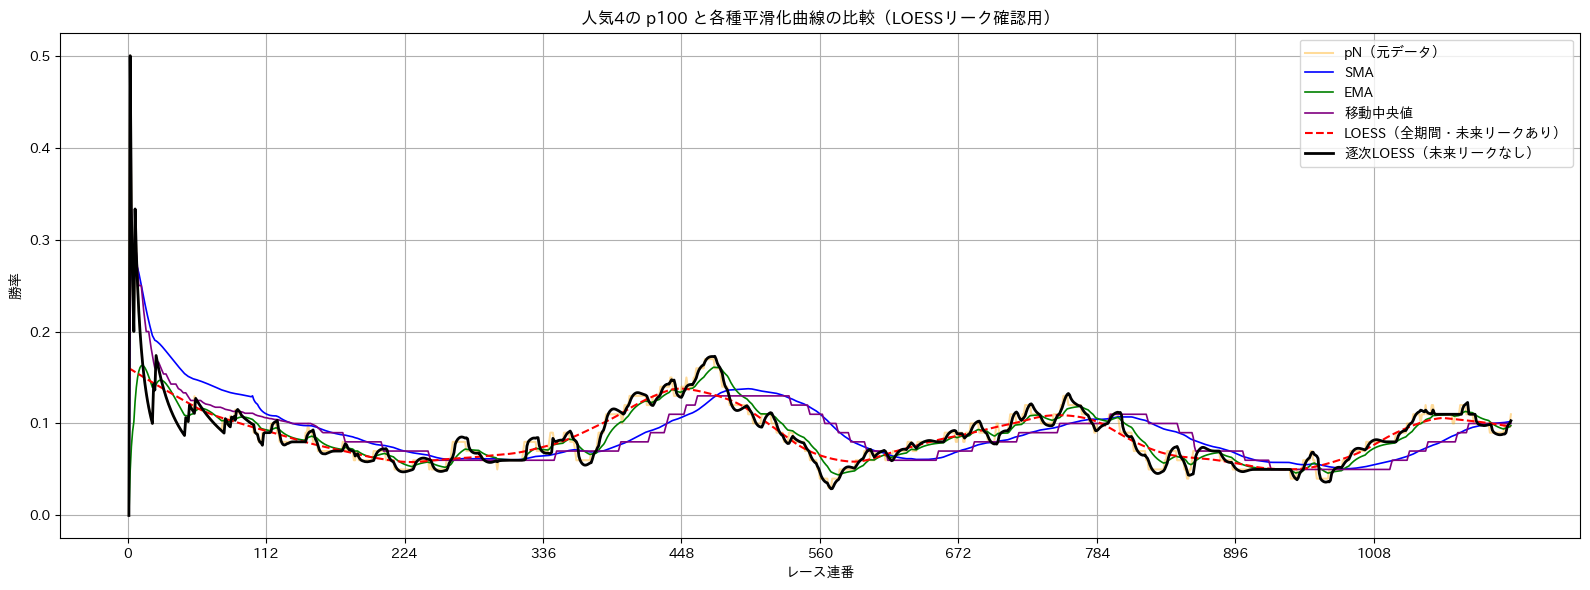

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- Êú™Êù•„É™„Éº„ÇØ„Å™„ÅóLOESSÈñ¢Êï∞ÔºàÈÄêÊ¨°LOESSÔºâ ---
def rolling_loess(y, frac=0.1, window=200):
    """
    ÈÅéÂéª„Éá„Éº„Çø„ÅÆ„Åø„Çí‰Ωø„Å£„ÅüÈÄêÊ¨°LOESSÔºàÊì¨‰ººLOESSÔºâ„ÇíË®àÁÆó„Åô„ÇãÈñ¢Êï∞„ÄÇ
    """
    n = len(y)
    loess_seq = np.full(n, np.nan)
    for i in tqdm(range(n), desc="ÈÄêÊ¨°LOESSË®àÁÆó‰∏≠"):
        start = max(0, i - window)
        y_sub = y[start:i + 1]
        x_sub = np.arange(len(y_sub))
        if len(y_sub) < 5:
            loess_seq[i] = y_sub[-1]
            continue
        smoothed = lowess(y_sub, x_sub, frac=frac, return_sorted=False)
        loess_seq[i] = smoothed[-1]
    return loess_seq


# --- ÂØæË±°‰∫∫Ê∞ó„ÇíÊåáÂÆö ---
target_popularity = 4
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- p100 / pN Ë®àÁÆó ---
WINDOW_LONG = 60
N = 100
df_plot['p100'] = df_plot['is_win'].rolling(WINDOW_LONG, min_periods=1).mean().shift(1)
df_plot['pN'] = df_plot['is_win'].rolling(N, min_periods=1).mean().shift(1)

# --- ÁßªÂãïÂπ≥Âùá (SMA) ---
df_plot['pN_SMA'] = df_plot['pN'].rolling(N, min_periods=1).mean()

# --- ÊåáÊï∞ÁßªÂãïÂπ≥Âùá (EMA) ---
EMA_SPAN = 20
df_plot['pN_EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()

# --- ÁßªÂãï‰∏≠Â§ÆÂÄ§ ---
df_plot['pN_median'] = df_plot['pN'].rolling(N, min_periods=1).median()

# --- ÈÄöÂ∏∏LOESSÔºàÂÖ®„Éá„Éº„Çø‰ΩøÁî®„Éª„É™„Éº„ÇØ„ÅÇ„ÇäÔºâ ---
frac = 0.1
df_plot['pN_LOESS_leaky'] = lowess(df_plot['pN'], np.arange(len(df_plot)), frac=frac, return_sorted=False)

# --- Êú™Êù•„É™„Éº„ÇØ„Å™„ÅóLOESSÔºàÊì¨‰ººLOESSÔºâ ---
window = 200
df_plot['pN_LOESS_no_leak'] = rolling_loess(df_plot['pN'].values, frac=frac, window=window)

# --- „Ç∞„É©„Éï‰ΩúÊàê ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN'], label='pNÔºàÂÖÉ„Éá„Éº„ÇøÔºâ', color='orange', alpha=0.4)
plt.plot(x, df_plot['pN_SMA'], label='SMA', color='blue', linewidth=1.2)
plt.plot(x, df_plot['pN_EMA'], label='EMA', color='green', linewidth=1.2)
plt.plot(x, df_plot['pN_median'], label='ÁßªÂãï‰∏≠Â§ÆÂÄ§', color='purple', linewidth=1.2)
plt.plot(x, df_plot['pN_LOESS_leaky'], label='LOESSÔºàÂÖ®ÊúüÈñì„ÉªÊú™Êù•„É™„Éº„ÇØ„ÅÇ„ÇäÔºâ', color='red', linestyle='--')
plt.plot(x, df_plot['pN_LOESS_no_leak'], label='ÈÄêÊ¨°LOESSÔºàÊú™Êù•„É™„Éº„ÇØ„Å™„ÅóÔºâ', color='black', linewidth=2)

# Ê®™Ëª∏„ÅÆÁõÆÁõõ„Çä„ÅØ‰∏ÄÂÆöÈñìÈöî
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('„É¨„Éº„ÇπÈÄ£Áï™')
plt.ylabel('ÂãùÁéá')
plt.title(f'‰∫∫Ê∞ó{target_popularity}„ÅÆ p{N} „Å®ÂêÑÁ®ÆÂπ≥ÊªëÂåñÊõ≤Á∑ö„ÅÆÊØîËºÉÔºàLOESS„É™„Éº„ÇØÁ¢∫Ë™çÁî®Ôºâ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- ‰ø°È†ºÂå∫ÈñìÈñ¢Êï∞ ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- Êú™Êù•„É™„Éº„ÇØ„Å™„ÅóLOESSÔºàÈÄêÊ¨°LOESSÔºâ ---
def rolling_loess(y, frac=0.1, window=200):
    n = len(y)
    loess_seq = np.full(n, np.nan)
    for i in tqdm(range(n), desc="ÈÄêÊ¨°LOESSË®àÁÆó‰∏≠", leave=False):
        start = max(0, i - window)
        y_sub = y[start:i + 1]
        x_sub = np.arange(len(y_sub))
        if len(y_sub) < 5:
            loess_seq[i] = y_sub[-1]
            continue
        smoothed = lowess(y_sub, x_sub, frac=frac, return_sorted=False)
        loess_seq[i] = smoothed[-1]
    return loess_seq

# --- „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ---
target_popularity = 4
N = 100
bet_amount = 100
EMA_SPAN = 20
prob_threshold = 0.5
loess_frac = 0.1
min_odds = 1.1
max_odds = 100

# --- „Éá„Éº„ÇøÊ∫ñÂÇô ---
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- ÂãùÁéá„Å®EMA ---
df_plot['pN'] = df_plot['is_win'].rolling(N, min_periods=1).mean().shift(1)
df_plot['EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()
df_plot['EMA_slope'] = df_plot['EMA'].diff()

# --- ÈÄöÂ∏∏LOESSÔºàÊú™Êù•„É™„Éº„ÇØ„ÅÇ„ÇäÔºâ ---
x = np.arange(len(df_plot))
loess_smoothed = lowess(df_plot['pN'], x, frac=loess_frac, return_sorted=False)
df_plot['loess'] = loess_smoothed
df_plot['loess_slope'] = np.gradient(loess_smoothed)
df_plot['loess_slope2'] = np.gradient(df_plot['loess_slope'])

# --- ‚úÖ ÈÄêÊ¨°LOESSÔºàÊú™Êù•„É™„Éº„ÇØ„Å™„ÅóÔºâ ---
df_plot['loess_seq'] = rolling_loess(df_plot['pN'].values, frac=loess_frac, window=200)
df_plot['loess_seq_slope'] = np.gradient(df_plot['loess_seq'])
df_plot['loess_seq_slope2'] = np.gradient(df_plot['loess_seq_slope'])

# --- ÂêÑÊù°‰ª∂„É≠„Ç∏„ÉÉ„ÇØÂÆöÁæ©ÔºàprobÊù°‰ª∂‰ªò„ÅçÔºâ ---
df_plot['cond_trend_prob'] = (df_plot['EMA_slope'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_mean_rev_prob'] = (df_plot['pN'] < df_plot['EMA']) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_hybrid_prob'] = (df_plot['EMA_slope'] > 0) & (df_plot['pN'] < df_plot['EMA']) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_slope_strong_prob'] = (df_plot['EMA_slope'] > df_plot['EMA_slope'].quantile(0.75)) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_cross_prob'] = ((df_plot['pN'].shift(1) < df_plot['EMA'].shift(1)) & (df_plot['pN'] >= df_plot['EMA'])) & (df_plot['pred_prob_m1'] >= prob_threshold)

# --- LOESSÁ≥ªÔºà‚ë•„Äú‚ëßÔºâ ---
df_plot['cond_loess_slope_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_loess_hybrid_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['pN'] < df_plot['loess']) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_loess_slope2_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['loess_slope2'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)

# --- ‚úÖ Êñ∞Ë¶èËøΩÂä†: ÈÄêÊ¨°LOESSÁ≥ªÔºà‚ë®„Äú‚ë™Ôºâ ---
df_plot['cond_seq_loess_slope_prob'] = (df_plot['loess_seq_slope'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_seq_loess_hybrid_prob'] = (df_plot['loess_seq_slope'] > 0) & (df_plot['pN'] < df_plot['loess_seq']) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_seq_loess_slope2_prob'] = (df_plot['loess_seq_slope'] > 0) & (df_plot['loess_seq_slope2'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)

# --- „Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥Èñ¢Êï∞ ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None):
    if cond_col:
        bets = df[df[cond_col]].copy()
    else:
        bets = df.copy()
    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    if total_bets == 0:
        return {'bets': 0, 'wins': 0, 'accuracy': 0, 'roi': 0, 'ci': (np.nan, np.nan)}

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['roi_each'] = bets['is_win'] * bets['odds']
    payout = (bets['roi_each'] * bet_amount).sum()
    total_spent = total_bets * bet_amount
    roi = payout / total_spent if total_spent > 0 else 0

    std = bets['roi_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)
    return {'bets': total_bets, 'wins': wins, 'accuracy': accuracy, 'roi': roi, 'ci': (lower, upper)}


# --- 11„É≠„Ç∏„ÉÉ„ÇØÊØîËºÉ ---
results_prob = {
    '‚ë† „Éà„É¨„É≥„ÉâËøΩÈöèÔºàEMA‰∏äÊòá & probÔºâ': simulate_hits(df_plot, 'cond_trend_prob', min_odds, max_odds),
    '‚ë° Âπ≥ÂùáÂõûÂ∏∞ÔºàpN < EMA & probÔºâ': simulate_hits(df_plot, 'cond_mean_rev_prob', min_odds, max_odds),
    '‚ë¢ „Éè„Ç§„Éñ„É™„ÉÉ„ÉâÔºà‰∏äÊòáÔºÜÂπ≥Âùá‰∏ã & probÔºâ': simulate_hits(df_plot, 'cond_hybrid_prob', min_odds, max_odds),
    '‚ë£ Âº∑„Éà„É¨„É≥„Éâ„ÅÆ„ÅøÔºàÂÇæ„Åç‰∏ä‰Ωç25% & probÔºâ': simulate_hits(df_plot, 'cond_slope_strong_prob', min_odds, max_odds),
    '‚ë§ „ÇØ„É≠„ÇπÊ§úÁü•ÔºàpN„ÅåEMA„Çí‰∏äÊäú„Åë & probÔºâ': simulate_hits(df_plot, 'cond_cross_prob', min_odds, max_odds),
    '‚ë• LOESSÂÇæ„Åç>0ÔºàÊªë„Çâ„Åã„Å™‰∏äÊòá & probÔºâ': simulate_hits(df_plot, 'cond_loess_slope_prob', min_odds, max_odds),
    '‚ë¶ LOESS‰∏äÊòáÔºÜpN<LOESS & prob': simulate_hits(df_plot, 'cond_loess_hybrid_prob', min_odds, max_odds),
    '‚ëß LOESSÂÇæ„Åç>0„Åã„Å§ÂÇæ„Åç„ÅÆÂÇæ„Åç>0': simulate_hits(df_plot, 'cond_loess_slope2_prob', min_odds, max_odds),
    '‚ë® ÈÄêÊ¨°LOESSÂÇæ„Åç>0ÔºàÊú™Êù•„É™„Éº„ÇØ„Å™„ÅóÔºâ': simulate_hits(df_plot, 'cond_seq_loess_slope_prob', min_odds, max_odds),
    '‚ë© ÈÄêÊ¨°LOESS‰∏äÊòáÔºÜpN<ÈÄêÊ¨°LOESS & prob': simulate_hits(df_plot, 'cond_seq_loess_hybrid_prob', min_odds, max_odds),
    '‚ë™ ÈÄêÊ¨°LOESSÂÇæ„Åç>0„Åã„Å§ÂÇæ„Åç„ÅÆÂÇæ„Åç>0': simulate_hits(df_plot, 'cond_seq_loess_slope2_prob', min_odds, max_odds),
}

# --- Âá∫Âäõ ---
print("\n==============================")
print(f"üéØ ‰∫∫Ê∞ó{target_popularity}Áï™„ÅÆ 11„É≠„Ç∏„ÉÉ„ÇØÊØîËºÉ")
print("==============================")

print("\n--- Ë®≠ÂÆö„Éë„É©„É°„Éº„Çø ---")
params = {
    "target_popularity": target_popularity,
    "N": N,
    "bet_amount": bet_amount,
    "EMA_SPAN": EMA_SPAN,
    "prob_threshold": prob_threshold,
    "loess_frac": loess_frac,
    "min_odds": min_odds,
    "max_odds": max_odds,
}
for k, v in params.items():
    print(f"{k}: {v}")

# --- ÂêÑ„É≠„Ç∏„ÉÉ„ÇØÁµêÊûúË°®Á§∫ ---
for key, res in results_prob.items():
    print(f"\n--- {key} ---")
    print(f"Ë≥ºÂÖ•Êï∞: {res['bets']}„ÄÅÁöÑ‰∏≠Êï∞: {res['wins']}")
    print(f"ÁöÑ‰∏≠Áéá: {res['accuracy']:.2%}")
    print(f"ÂõûÂèéÁéá: {res['roi']:.3f}")
    print(f"90%‰ø°È†ºÂå∫Èñì: ({res['ci'][0]:.3f}, {res['ci'][1]:.3f})")



üéØ ‰∫∫Ê∞ó4Áï™„ÅÆ 11„É≠„Ç∏„ÉÉ„ÇØÊØîËºÉ

--- Ë®≠ÂÆö„Éë„É©„É°„Éº„Çø ---
target_popularity: 4
N: 100
bet_amount: 100
EMA_SPAN: 20
prob_threshold: 0.5
loess_frac: 0.1
min_odds: 1.1
max_odds: 100

--- ‚ë† „Éà„É¨„É≥„ÉâËøΩÈöèÔºàEMA‰∏äÊòá & probÔºâ ---
Ë≥ºÂÖ•Êï∞: 220„ÄÅÁöÑ‰∏≠Êï∞: 24
ÁöÑ‰∏≠Áéá: 10.91%
ÂõûÂèéÁéá: 0.859
90%‰ø°È†ºÂå∫Èñì: (0.560, 1.158)

--- ‚ë° Âπ≥ÂùáÂõûÂ∏∞ÔºàpN < EMA & probÔºâ ---
Ë≥ºÂÖ•Êï∞: 264„ÄÅÁöÑ‰∏≠Êï∞: 27
ÁöÑ‰∏≠Áéá: 10.23%
ÂõûÂèéÁéá: 0.927
90%‰ø°È†ºÂå∫Èñì: (0.614, 1.240)

--- ‚ë¢ „Éè„Ç§„Éñ„É™„ÉÉ„ÉâÔºà‰∏äÊòáÔºÜÂπ≥Âùá‰∏ã & probÔºâ ---
Ë≥ºÂÖ•Êï∞: 0„ÄÅÁöÑ‰∏≠Êï∞: 0
ÁöÑ‰∏≠Áéá: 0.00%
ÂõûÂèéÁéá: 0.000
90%‰ø°È†ºÂå∫Èñì: (nan, nan)

--- ‚ë£ Âº∑„Éà„É¨„É≥„Éâ„ÅÆ„ÅøÔºàÂÇæ„Åç‰∏ä‰Ωç25% & probÔºâ ---
Ë≥ºÂÖ•Êï∞: 117„ÄÅÁöÑ‰∏≠Êï∞: 12
ÁöÑ‰∏≠Áéá: 10.26%
ÂõûÂèéÁéá: 0.792
90%‰ø°È†ºÂå∫Èñì: (0.412, 1.173)

--- ‚ë§ „ÇØ„É≠„ÇπÊ§úÁü•ÔºàpN„ÅåEMA„Çí‰∏äÊäú„Åë & probÔºâ ---
Ë≥ºÂÖ•Êï∞: 16„ÄÅÁöÑ‰∏≠Êï∞: 3
ÁöÑ‰∏≠Áéá: 18.75%
ÂõûÂèéÁéá: 1.519
90%‰ø°È†ºÂå∫Èñì: (-0.009, 3.047)

--- ‚ë• LOESSÂÇæ„Åç>0ÔºàÊªë„Çâ„Åã„Å™

In [59]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- ‰ø°È†ºÂå∫ÈñìÈñ¢Êï∞ ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- „Éë„É©„É°„Éº„Çø ---
N = 100
bet_amount = 100
EMA_SPAN = 20
prob_threshold = 0.5
loess_frac = 0.1
min_odds = 1.1
max_odds = 10000

# --- „Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥Èñ¢Êï∞ ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None):
    if cond_col:
        bets = df[df[cond_col]].copy()
    else:
        bets = df.copy()

    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    total_spent = total_bets * bet_amount

    if total_bets == 0:
        return {
            'bets': 0, 'wins': 0, 'accuracy': 0,
            'roi': 0, 'payout': 0, 'spent': 0,
            'ci': (np.nan, np.nan)
        }

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    payout = bets['payout_each'].sum()
    roi = payout / total_spent if total_spent > 0 else 0
    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'payout': payout,
        'spent': total_spent,
        'ci': (lower, upper)
    }

# --- ÈÄêÊ¨°LOESSË®àÁÆóÔºàfillna„Ç™„Éó„Ç∑„Éß„É≥ & skip_initial„Ç™„Éó„Ç∑„Éß„É≥‰ªò„ÅçÔºâ ---
def compute_sequential_loess(df, loess_frac, fillna_option=None, skip_initial=0):
    df['pN'] = df['is_win'].rolling(N, min_periods=1).mean().shift(1)
    
    # fillna„Ç™„Éó„Ç∑„Éß„É≥Âá¶ÁêÜ
    if fillna_option is not None:
        df['pN'] = df['pN'].fillna(fillna_option)
    
    loess_seq = []
    for i in range(len(df)):
        if i < skip_initial:
            loess_seq.append(np.nan)
            continue

        start_idx = max(skip_initial, i - int(loess_frac*len(df)))
        end_idx = i + 1
        if end_idx - start_idx < 2:
            loess_seq.append(df['pN'].iloc[i])
            continue
        smoothed = lowess(df['pN'].iloc[start_idx:end_idx], 
                          np.arange(end_idx - start_idx), frac=1.0, return_sorted=False)
        loess_seq.append(smoothed[-1])
        
    df['loess_seq'] = loess_seq
    df['loess_seq_slope'] = np.gradient(df['loess_seq'], edge_order=2)
    df['loess_seq_slope2'] = np.gradient(df['loess_seq_slope'], edge_order=2)
    
    return df

# --- Êù°‰ª∂ÂÆöÁæ© ---
conditions = {
    '09': lambda df: df['loess_seq_slope'] > 0,
    '10': lambda df: (df['loess_seq_slope'] > 0) & (df['pN'] < df['loess_seq']),
    '11': lambda df: (df['loess_seq_slope'] > 0) & (df['loess_seq_slope2'] > 0)
}

# --- „Åì„Åì„Åß„Å©„Çå„ÇíË®àÁÆó„Åô„Çã„ÅãÊåáÂÆö ---
target_cond = '11'  # 09, 10, 11 „ÅÆ„Å©„Çå„Åã
fillna_option = None  # None „Åæ„Åü„ÅØ 0 „Å™„Å©
skip_initial = N    # ÊúÄÂàù„ÅÆ N Ë°å„ÇíÁÑ°Ë¶ñÔºà0„Åæ„Åü„ÅØN„Å´„Åô„ÇãÔºâ

print("\n" + "="*30)
print(f"üéØ Êù°‰ª∂ {target_cond} ‰∫∫Ê∞ó„Åî„Å®„Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥")
print("="*30)

results_all = []
all_bets_df = []

for pop in sorted(full_pred_df['popularity'].unique()):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    df_pop = compute_sequential_loess(df_pop, loess_frac, fillna_option, skip_initial)

    df_pop['cond'] = conditions[target_cond](df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)

    res = simulate_hits(df_pop, 'cond', min_odds, max_odds)

    results_all.append({
        'popularity': pop,
        'bets': res['bets'],
        'wins': res['wins'],
        'spent': res['spent'],
        'payout': res['payout'],
        'accuracy': res['accuracy'],
        'roi': res['roi'],
        'ci_lower': res['ci'][0],
        'ci_upper': res['ci'][1]
    })

    all_bets_df.append(df_pop[df_pop['cond']])

df_all_bets = pd.concat(all_bets_df, ignore_index=True)
res_total = simulate_hits(df_all_bets, None, min_odds, max_odds)

df_result = pd.DataFrame(results_all)
df_result['accuracy_pct'] = df_result['accuracy'] * 100
df_result['roi_pct'] = df_result['roi'] * 100

# ÂêàË®àË°åËøΩÂä†
df_total = pd.DataFrame([{
    'popularity': 'ÂêàË®à',
    'bets': res_total['bets'],
    'wins': res_total['wins'],
    'spent': res_total['spent'],
    'payout': res_total['payout'],
    'accuracy': res_total['accuracy'],
    'roi': res_total['roi'],
    'ci_lower': res_total['ci'][0],
    'ci_upper': res_total['ci'][1],
    'accuracy_pct': res_total['accuracy'] * 100,
    'roi_pct': res_total['roi'] * 100
}])
df_result = pd.concat([df_result, df_total], ignore_index=True)

# --- „Éë„É©„É°„Éº„ÇøÂá∫Âäõ ---
print("\n--- „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ---")
print(f"N={N}, bet_amount={bet_amount}, EMA_SPAN={EMA_SPAN}, prob_threshold={prob_threshold}")
print(f"loess_frac={loess_frac}, min_odds={min_odds}, max_odds={max_odds}")
print(f"fillna_option={fillna_option}, skip_initial={skip_initial}\n")

# Âá∫Âäõ
print(df_result[['popularity', 'bets', 'wins', 'spent', 'payout', 'accuracy_pct', 'roi_pct']].to_string(
    index=False,
    formatters={
        'accuracy_pct': '{:.2f}'.format,
        'roi_pct': '{:.2f}'.format,
        'spent': '{:,.0f}'.format,
        'payout': '{:,.0f}'.format
    }
))

# CSVÂá∫Âäõ
df_result.to_csv(
    f'C:\\Users\\ryo\\Downloads\\loess_seq_{target_cond}_all_popularity.csv',
    index=False, encoding='cp932'
)



üéØ Êù°‰ª∂ 11 ‰∫∫Ê∞ó„Åî„Å®„Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥

--- „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ---
N=100, bet_amount=100, EMA_SPAN=20, prob_threshold=0.5
loess_frac=0.1, min_odds=1.1, max_odds=10000
fillna_option=None, skip_initial=100

popularity  bets  wins  spent  payout accuracy_pct roi_pct
       1.0   193   124 19,300  21,740        64.25  112.64
       2.0   189    77 18,900  25,620        40.74  135.56
       3.0   141    43 14,100  25,120        30.50  178.16
       4.0    98    27  9,800  23,070        27.55  235.41
       5.0    52     6  5,200   7,990        11.54  153.65
       6.0    42     6  4,200   8,320        14.29  198.10
       7.0    28     0  2,800       0         0.00    0.00
       8.0     9     2    900   4,680        22.22  520.00
       9.0     5     0    500       0         0.00    0.00
        ÂêàË®à   757   285 75,700 116,540        37.65  153.95


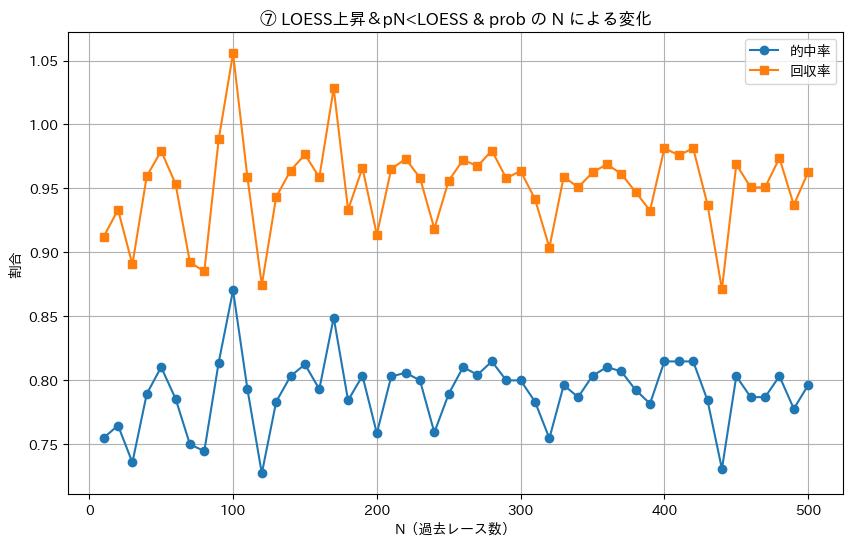

In [649]:
import matplotlib.pyplot as plt

# --- N„ÅÆÁØÑÂõ≤Ë®≠ÂÆö ---
N_values = range(10, 501, 10)  # ‰æã: 20„Åã„Çâ200„Åæ„Åß10Âàª„Åø
accuracy_list = []
roi_list = []

for N_test in N_values:
    df_plot['pN'] = df_plot['is_win'].rolling(N_test, min_periods=1).mean().shift(1)
    df_plot['EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()
    
    # LOESS „ÅØ„Åù„ÅÆ„Åæ„ÅæÂÜçË®àÁÆó
    loess_smoothed = lowess(df_plot['pN'], x, frac=loess_frac, return_sorted=False)
    df_plot['loess'] = loess_smoothed

    # ‚ë¶Êù°‰ª∂
    df_plot['cond_loess_hybrid_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['pN'] < df_plot['loess']) & (df_plot['pred_prob_m1'] >= prob_threshold)

    res = simulate_hits(df_plot, 'cond_loess_hybrid_prob', min_odds, max_odds)
    accuracy_list.append(res['accuracy'])
    roi_list.append(res['roi'])

# --- „Ç∞„É©„ÉïÊèèÁîª ---
plt.figure(figsize=(10, 6))
plt.plot(N_values, accuracy_list, marker='o', label='ÁöÑ‰∏≠Áéá')
plt.plot(N_values, roi_list, marker='s', label='ÂõûÂèéÁéá')
plt.xlabel('NÔºàÈÅéÂéª„É¨„Éº„ÇπÊï∞Ôºâ')
plt.ylabel('Ââ≤Âêà')
plt.title('‚ë¶ LOESS‰∏äÊòáÔºÜpN<LOESS & prob „ÅÆ N „Å´„Çà„ÇãÂ§âÂåñ')
plt.grid(True)
plt.legend()
plt.show()


In [485]:
# ============================================================
# ‚úÖ ÂÆåÂÖ®Áµ±ÂêàÁâàÔºöÁ¢∫ÁéáÊù°‰ª∂ √ó Êù°‰ª∂1 √ó Êù°‰ª∂1.5 √ó Rebound √ó „Ç™„ÉÉ„Ç∫Êù°‰ª∂
# ============================================================

import pandas as pd
import numpy as np
from scipy import stats

# --- ‰ø°È†ºÂå∫ÈñìÈñ¢Êï∞ ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ---
target_popularity = 1       # ÂØæË±°‰∫∫Ê∞ó
compared_popularity = 2     # ÊØîËºÉ‰∫∫Ê∞ó
target_threshold = 0.5      # ÂØæË±°‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá‰∏ãÈôê
compared_threshold = 1.0    # ÊØîËºÉ‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá‰∏äÈôê
use_prob_filter = True      # Á¢∫Áéá„Éï„Ç£„É´„Çø„Çí‰Ωø„ÅÜ„Åã
N = 50                      # Áõ¥ËøëN„É¨„Éº„Çπ
WINDOW_LONG = 200           # p100„ÅÆ„Ç¶„Ç£„É≥„Éâ„Ç¶„Çµ„Ç§„Ç∫
bet_amount = 100            # 1„É¨„Éº„Çπ„ÅÇ„Åü„Çä„ÅÆË≥ºÂÖ•È°ç
min_diff = 0.08             # Êù°‰ª∂1.5„ÉªRebound„Å´ÂøÖË¶Å„Å™Â∑Æ
stop_margin = 0.01           # Rebound„Åß„ÅÆË≥ºÂÖ•ÂÅúÊ≠¢Êù°‰ª∂
min_odds = 1.1              # ÊúÄÂ∞è„Ç™„ÉÉ„Ç∫
max_odds = 1000.0              # ÊúÄÂ§ß„Ç™„ÉÉ„Ç∫

# --- „Éá„Éº„ÇøË™≠„ÅøËæº„Åø ---
df = full_pred_df.copy()  # full_pred_df „ÅØÂâçÊÆµ„Åß‰Ωú„Çâ„Çå„Å¶„ÅÑ„ÇãÂâçÊèê
if 'race_date' in df.columns:
    df = df.sort_values(['race_date', 'race_id'])
else:
    df = df.sort_values('race_id')

# --- ÂØæË±°‰∫∫Ê∞óÊäΩÂá∫ ---
df_pop = df[df['popularity'] == target_popularity].copy()
df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

# --- Á¢∫ÁéáÊù°‰ª∂„Éï„Ç£„É´„Çø ---
if use_prob_filter:
    compared_probs = (
        df[df['popularity'] == compared_popularity]
        .loc[:, ['race_id', 'pred_prob_m1']]
        .rename(columns={'pred_prob_m1': f'pop{compared_popularity}_prob'})
    )
    df_pop = df_pop.merge(compared_probs, on='race_id', how='left')
    df_pop['cond_prob'] = (
        (df_pop['pred_prob_m1'] >= target_threshold) &
        (df_pop[f'pop{compared_popularity}_prob'] <= compared_threshold)
    )
else:
    df_pop['cond_prob'] = True

# --- „Ç™„ÉÉ„Ç∫Êù°‰ª∂„Éï„Ç£„É´„Çø ---
df_pop['cond_odds'] = (df_pop['odds'] >= min_odds) & (df_pop['odds'] <= max_odds)

# --- p100 / pN Ë®àÁÆóÔºàWINDOW_LONGÊú™Ê∫Ä„ÅÆ„É¨„Éº„Çπ„ÅØNaNÊâ±„ÅÑÔºâ ---
df_pop['p100'] = df_pop['is_win'].rolling(WINDOW_LONG, min_periods=WINDOW_LONG).mean().shift(1)
df_pop['pN'] = df_pop['is_win'].rolling(N, min_periods=1).mean().shift(1)

# --- Êù°‰ª∂1: pN < p100Ôºà‰∏çË™øÊúüË≥ºÂÖ•Ôºâ ---
df_pop['cond_pN_lt_p100'] = df_pop['pN'] < df_pop['p100']

# --- Êù°‰ª∂1.5: ‰∏≠ÈñìÁ≠ñÔºàpN < p100 - min_diff„ÅßË≥ºÂÖ•ÈñãÂßã„ÄÅpN >= p100„ÅßÂÅúÊ≠¢Ôºâ ---
df_pop['cond_intermediate'] = False
is_active = False
for i in range(len(df_pop)):
    if not is_active and pd.notna(df_pop['p100'].iloc[i]) and df_pop['pN'].iloc[i] < df_pop['p100'].iloc[i] - min_diff:
        is_active = True
    if is_active:
        df_pop.at[df_pop.index[i], 'cond_intermediate'] = True
        if df_pop['pN'].iloc[i] >= df_pop['p100'].iloc[i]:
            is_active = False

# --- Êù°‰ª∂2: ReboundÈñãÂßãÔºàpN„Åå‰∏äÊòá„Å´Ëª¢„Åò„ÄÅpN<p100Ôºâ ---
df_pop['delta_pN'] = df_pop['pN'].diff()
df_pop['cond_rebound'] = (
    (df_pop['pN'].shift(1) < df_pop['p100']) &
    (df_pop['delta_pN'] > 0) &
    ((df_pop['p100'] - df_pop['pN']) >= min_diff)
)

# --- Êù°‰ª∂2Á∂ôÁ∂ö: stop_marginÂØæÂøú ---
df_pop['cond_rebound_stop'] = False
is_active = False
for i in range(len(df_pop)):
    if df_pop['cond_rebound'].iloc[i]:
        is_active = True
    if is_active:
        df_pop.at[df_pop.index[i], 'cond_rebound_stop'] = True
        if df_pop['pN'].iloc[i] >= df_pop['p100'].iloc[i] - stop_margin:
            is_active = False

# --- WINDOW_LONGÊú™Ê∫Ä„ÅÆ„É¨„Éº„Çπ„ÅØË≥ºÂÖ•ÂØæË±°Â§ñ„Å´Ë®≠ÂÆö ---
df_pop.loc[df_pop['p100'].isna(), ['cond_pN_lt_p100', 'cond_intermediate', 'cond_rebound', 'cond_rebound_stop']] = False

# --- „Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥Èñ¢Êï∞ ---
def simulate_hits(df, condition_column=None, confidence_level=0.90):
    if condition_column:
        bets = df[(df[condition_column] == True) & 
                  (df['cond_prob'] == True) &
                  (df['cond_odds'] == True)].copy()
    else:
        bets = df[(df['cond_prob'] == True) & (df['cond_odds'] == True)].copy()

    total_bets = len(bets)
    if total_bets == 0:
        return {'bets': 0, 'wins': 0, 'accuracy': 0, 'roi': 0, 'ci': (np.nan, np.nan)}

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['roi_each'] = bets['is_win'] * bets['odds']
    payout = (bets['roi_each'] * bet_amount).sum()
    total_spent = total_bets * bet_amount
    roi = payout / total_spent if total_spent > 0 else 0

    std = bets['roi_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets, confidence_level)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'ci': (lower, upper)
    }

# --- ÁµêÊûúÊØîËºÉ ---
results = {
    'AllÔºàÁ¢∫Áéá+„Ç™„ÉÉ„Ç∫Êù°‰ª∂Ôºâ': simulate_hits(df_pop),
    'pN < p100Ôºà‰∏çË™øÊúüË≥ºÂÖ•Ôºâ': simulate_hits(df_pop, 'cond_pN_lt_p100'),
    'Êù°‰ª∂1.5Ôºà‰∏≠ÈñìÁ≠ñÔºâ': simulate_hits(df_pop, 'cond_intermediate'),
    'ReboundÈñãÂßãÔºàÂèçÁô∫Ê§úÁü•Ôºâ': simulate_hits(df_pop, 'cond_rebound'),
    f'ReboundÁ∂ôÁ∂öÔºàstop_margin={stop_margin}Ôºâ': simulate_hits(df_pop, 'cond_rebound_stop')
}

# --- Âá∫Âäõ ---
print("\n==============================")
print("üìå „Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥„Éë„É©„É°„Éº„Çø")
print("==============================")
params = {
    "ÂØæË±°‰∫∫Ê∞ó": target_popularity,
    "ÊØîËºÉ‰∫∫Ê∞ó": compared_popularity,
    "ÂØæË±°‰∫∫Ê∞ó„ÅÆÁ¢∫Áéá‰∏ãÈôê": target_threshold,
    "ÊØîËºÉ‰∫∫Ê∞ó„ÅÆÁ¢∫Áéá‰∏äÈôê": compared_threshold,
    "Á¢∫Áéá„Éï„Ç£„É´„Çø‰ΩøÁî®": use_prob_filter,
    "Áõ¥ËøëN„É¨„Éº„Çπ": N,
    "p100„Ç¶„Ç£„É≥„Éâ„Ç¶„Çµ„Ç§„Ç∫": WINDOW_LONG,
    "„Éô„ÉÉ„ÉàÈ°ç": bet_amount,
    "Êù°‰ª∂Â∑ÆÂàÜ min_diff": min_diff,
    "ReboundÂÅúÊ≠¢„Éû„Éº„Ç∏„É≥ stop_margin": stop_margin,
    "ÊúÄÂ∞è„Ç™„ÉÉ„Ç∫": min_odds,
    "ÊúÄÂ§ß„Ç™„ÉÉ„Ç∫": max_odds
}

for k, v in params.items():
    print(f"{k}: {v}")

print("\n==============================")
print("üìå ÁµêÊûúÊØîËºÉ")
print("==============================")

for key, res in results.items():
    print(f"\n--- {key} ---")
    print(f"Ë≥ºÂÖ•Êï∞: {res['bets']}„ÄÅÁöÑ‰∏≠Êï∞: {res['wins']}")
    print(f"ÁöÑ‰∏≠Áéá: {res['accuracy']:.2%}")
    print(f"ÂõûÂèéÁéá: {res['roi']:.3f}")
    print(f"90%‰ø°È†ºÂå∫Èñì: ({res['ci'][0]:.3f}, {res['ci'][1]:.3f})")

# --- CSVÂá∫Âäõ ---
df_pop.to_csv(
    f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_prob_rebound_odds_analysis.csv',
    index=False, encoding='cp932'
)



üìå „Ç∑„Éü„É•„É¨„Éº„Ç∑„Éß„É≥„Éë„É©„É°„Éº„Çø
ÂØæË±°‰∫∫Ê∞ó: 1
ÊØîËºÉ‰∫∫Ê∞ó: 2
ÂØæË±°‰∫∫Ê∞ó„ÅÆÁ¢∫Áéá‰∏ãÈôê: 0.5
ÊØîËºÉ‰∫∫Ê∞ó„ÅÆÁ¢∫Áéá‰∏äÈôê: 1.0
Á¢∫Áéá„Éï„Ç£„É´„Çø‰ΩøÁî®: True
Áõ¥ËøëN„É¨„Éº„Çπ: 50
p100„Ç¶„Ç£„É≥„Éâ„Ç¶„Çµ„Ç§„Ç∫: 200
„Éô„ÉÉ„ÉàÈ°ç: 100
Êù°‰ª∂Â∑ÆÂàÜ min_diff: 0.08
ReboundÂÅúÊ≠¢„Éû„Éº„Ç∏„É≥ stop_margin: 0.01
ÊúÄÂ∞è„Ç™„ÉÉ„Ç∫: 1.1
ÊúÄÂ§ß„Ç™„ÉÉ„Ç∫: 1000.0

üìå ÁµêÊûúÊØîËºÉ

--- AllÔºàÁ¢∫Áéá+„Ç™„ÉÉ„Ç∫Êù°‰ª∂Ôºâ ---
Ë≥ºÂÖ•Êï∞: 1011„ÄÅÁöÑ‰∏≠Êï∞: 442
ÁöÑ‰∏≠Áéá: 43.72%
ÂõûÂèéÁéá: 0.762
90%‰ø°È†ºÂå∫Èñì: (0.714, 0.811)

--- pN < p100Ôºà‰∏çË™øÊúüË≥ºÂÖ•Ôºâ ---
Ë≥ºÂÖ•Êï∞: 474„ÄÅÁöÑ‰∏≠Êï∞: 204
ÁöÑ‰∏≠Áéá: 43.04%
ÂõûÂèéÁéá: 0.768
90%‰ø°È†ºÂå∫Èñì: (0.695, 0.841)

--- Êù°‰ª∂1.5Ôºà‰∏≠ÈñìÁ≠ñÔºâ ---
Ë≥ºÂÖ•Êï∞: 174„ÄÅÁöÑ‰∏≠Êï∞: 67
ÁöÑ‰∏≠Áéá: 38.51%
ÂõûÂèéÁéá: 0.689
90%‰ø°È†ºÂå∫Èñì: (0.571, 0.806)

--- ReboundÈñãÂßãÔºàÂèçÁô∫Ê§úÁü•Ôºâ ---
Ë≥ºÂÖ•Êï∞: 11„ÄÅÁöÑ‰∏≠Êï∞: 5
ÁöÑ‰∏≠Áéá: 45.45%
ÂõûÂèéÁéá: 0.764
90%‰ø°È†ºÂå∫Èñì: (0.231, 1.296)

--- ReboundÁ∂ôÁ∂öÔºàstop_margin=0.01Ôºâ ---
Ë≥ºÂÖ•Êï∞: 154„ÄÅÁöÑ‰∏

In [809]:
'''

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.5„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 45
  ÁöÑ‰∏≠Êï∞: 21
  ÁöÑ‰∏≠Áéá: 0.4667Ôºà46.67%Ôºâ
  ÂõûÂèéÁéá: 1.0556Ôºà105.56%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.746, 1.365)

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.7„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 34
  ÁöÑ‰∏≠Êï∞: 15
  ÁöÑ‰∏≠Áéá: 0.4412Ôºà44.12%Ôºâ
  ÂõûÂèéÁéá: 1.1235Ôºà112.35%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.732, 1.515)

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.85 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.55 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.5„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 41
  ÁöÑ‰∏≠Êï∞: 19
  ÁöÑ‰∏≠Áéá: 0.4634Ôºà46.34%Ôºâ
  ÂõûÂèéÁéá: 1.0683Ôºà106.83%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.736, 1.400)

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.55 ÔºÜ „Ç™„ÉÉ„Ç∫ 2.5„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 27
  ÁöÑ‰∏≠Êï∞: 11
  ÁöÑ‰∏≠Áéá: 0.4074Ôºà40.74%Ôºâ
  ÂõûÂèéÁéá: 1.2185Ôºà121.85%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.723, 1.714)

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.9 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 20
  ÁöÑ‰∏≠Êï∞: 13
  ÁöÑ‰∏≠Áéá: 0.6500Ôºà65.00%Ôºâ
  ÂõûÂèéÁéá: 1.2100Ôºà121.00%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.768, 1.652)

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.9 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 28
  ÁöÑ‰∏≠Êï∞: 18
  ÁöÑ‰∏≠Áéá: 0.6429Ôºà64.29%Ôºâ
  ÂõûÂèéÁéá: 1.0750Ôºà107.50%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.743, 1.407)

‚ñº Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 1.0 ÔºÜ „Ç™„ÉÉ„Ç∫ 2.7„Äú1000.0
  Ë≥ºÂÖ•Êï∞: 74
  ÁöÑ‰∏≠Êï∞: 24
  ÁöÑ‰∏≠Áéá: 0.3243Ôºà32.43%Ôºâ
  ÂõûÂèéÁéá: 0.9865Ôºà98.65%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.706, 1.267)

‚ñº Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú100.0
  Ë≥ºÂÖ•Êï∞: 17
  ÁöÑ‰∏≠Êï∞: 11
  ÁöÑ‰∏≠Áéá: 0.6471Ôºà64.71%Ôºâ
  ÂõûÂèéÁéá: 1.0235Ôºà102.35%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.652, 1.396)

‚ñº Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.87 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.72 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú100.0
  Ë≥ºÂÖ•Êï∞: 50
  ÁöÑ‰∏≠Êï∞: 33
  ÁöÑ‰∏≠Áéá: 0.6600Ôºà66.00%Ôºâ
  ÂõûÂèéÁéá: 0.9900Ôºà99.00%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.810, 1.170)

 Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.9 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 1.0 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú100.0
  Ë≥ºÂÖ•Êï∞: 29
  ÁöÑ‰∏≠Êï∞: 20
  ÁöÑ‰∏≠Áéá: 0.6897Ôºà68.97%Ôºâ
  ÂõûÂèéÁéá: 1.0034Ôºà100.34%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.775, 1.232)

target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú20.0
  Ë≥ºÂÖ•Êï∞: 29
  ÁöÑ‰∏≠Êï∞: 5
  ÁöÑ‰∏≠Áéá: 0.1724Ôºà17.24%Ôºâ
  ÂõûÂèéÁéá: 1.1241Ôºà112.41%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.316, 1.932)
target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.0 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 1.0 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 166
  ÁöÑ‰∏≠Êï∞: 51
  ÁöÑ‰∏≠Áéá: 0.3072Ôºà30.72%Ôºâ
  ÂõûÂèéÁéá: 1.1271Ôºà112.71%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.895, 1.359)
target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 1.0 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 126
  ÁöÑ‰∏≠Êï∞: 45
  ÁöÑ‰∏≠Áéá: 0.3571Ôºà35.71%Ôºâ
  ÂõûÂèéÁéá: 1.3143Ôºà131.43%Ôºâ
‰ø°È†ºÂå∫Èñì: (1.035, 1.593) # ‰ø°È†ºÂå∫Èñì„Åå1.0„ÇíË∂Ö„Åà„ÅüÔºÅ„Åó„Åã„ÇÇ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 1.0 „ÅßÔºÅ
 target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.75 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 76
  ÁöÑ‰∏≠Êï∞: 25
  ÁöÑ‰∏≠Áéá: 0.3289Ôºà32.89%Ôºâ
  ÂõûÂèéÁéá: 1.1592Ôºà115.92%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.830, 1.488)
target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.69 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 48
  ÁöÑ‰∏≠Êï∞: 18
  ÁöÑ‰∏≠Áéá: 0.3750Ôºà37.50%Ôºâ
  ÂõûÂèéÁéá: 1.3812Ôºà138.12%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.929, 1.834)
target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.67 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 42
  ÁöÑ‰∏≠Êï∞: 14
  ÁöÑ‰∏≠Áéá: 0.3333Ôºà33.33%Ôºâ
  ÂõûÂèéÁéá: 1.2952Ôºà129.52%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.800, 1.790)
target_race_numbers = [10, 12]
‚ñº Êù°‰ª∂Ôºö9È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ9È†≠ ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.58 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.67 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 31
  ÁöÑ‰∏≠Êï∞: 12
  ÁöÑ‰∏≠Áéá: 0.3871Ôºà38.71%Ôºâ
  ÂõûÂèéÁéá: 1.4710Ôºà147.10%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.879, 2.063)

‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.87 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.9„Äú10.0
  Ë≥ºÂÖ•Êï∞: 34
  ÁöÑ‰∏≠Êï∞: 16
  ÁöÑ‰∏≠Áéá: 0.4706Ôºà47.06%Ôºâ
  ÂõûÂèéÁéá: 1.1882Ôºà118.82%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.804, 1.573)

‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6 ÔºÜ „Ç™„ÉÉ„Ç∫ 2.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 58
  ÁöÑ‰∏≠Êï∞: 24
  ÁöÑ‰∏≠Áéá: 0.4138Ôºà41.38%Ôºâ
  ÂõûÂèéÁéá: 1.1328Ôºà113.28%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.823, 1.442)

12R„ÅÆ„Åø„ÄÇ1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„Åå‰Ωé„ÇÅ„Å™„ÅÆ„Å´„Åì„ÅÆÁöÑ‰∏≠Áéá„ÅØ„Åô„Åî„ÅÑ
‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.65 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 28
  ÁöÑ‰∏≠Êï∞: 17
  ÁöÑ‰∏≠Áéá: 0.6071Ôºà60.71%Ôºâ
  ÂõûÂèéÁéá: 1.1571Ôºà115.71%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.808, 1.506)
1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„Çí‰∏ä„Åí„Å¶„Åø„Åü„ÄÇ
‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 25
  ÁöÑ‰∏≠Êï∞: 16
  ÁöÑ‰∏≠Áéá: 0.6400Ôºà64.00%Ôºâ
  ÂõûÂèéÁéá: 1.1960Ôºà119.60%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.832, 1.560)
‚ñº Êù°‰ª∂Ôºö10È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ10È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú10.0
  Ë≥ºÂÖ•Êï∞: 20
  ÁöÑ‰∏≠Êï∞: 15
  ÁöÑ‰∏≠Áéá: 0.7500Ôºà75.00%Ôºâ
  ÂõûÂèéÁéá: 1.3450Ôºà134.50%Ôºâ
‰ø°È†ºÂå∫Èñì: (0.971, 1.719) # ‰ø°È†ºÂå∫Èñì„ÅåÈ´ò„ÅÑÔºÅ
'''
### „ÄêÂá∫Âäõ„É°„É¢„Äë
### 2023Âπ¥„ÇíÂ≠¶Áøí„Åó2024Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 42
#   ÁöÑ‰∏≠Êï∞: 13
#   ÁöÑ‰∏≠Áéá: 0.3095Ôºà30.95%Ôºâ
#   ÂõûÂèéÁéá: 1.4762Ôºà147.62%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 76
#   ÁöÑ‰∏≠Êï∞: 22
#   ÁöÑ‰∏≠Áéá: 0.2895Ôºà28.95%Ôºâ
#   ÂõûÂèéÁéá: 1.4132Ôºà141.32%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 37
#   ÁöÑ‰∏≠Êï∞: 14
#   ÁöÑ‰∏≠Áéá: 0.3784Ôºà37.84%Ôºâ
#   ÂõûÂèéÁéá: 1.7027Ôºà170.27%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.55
#   Ë≥ºÂÖ•Êï∞: 20
#   ÁöÑ‰∏≠Êï∞: 3
#   ÁöÑ‰∏≠Áéá: 0.1500Ôºà15.00%Ôºâ
#   ÂõûÂèéÁéá: 1.3150Ôºà131.50%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö5Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.65 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 23
#   ÁöÑ‰∏≠Êï∞: 4
#   ÁöÑ‰∏≠Áéá: 0.1739Ôºà17.39%Ôºâ
#   ÂõûÂèéÁéá: 1.9478Ôºà194.78%Ôºâ
### 2022Âπ¥„ÇíÂ≠¶Áøí„Åó2023Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 21
#   ÁöÑ‰∏≠Êï∞: 5
#   ÁöÑ‰∏≠Áéá: 0.2381Ôºà23.81%Ôºâ
#   ÂõûÂèéÁéá: 1.2429Ôºà124.29%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö4Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.7 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 23
#   ÁöÑ‰∏≠Êï∞: 3
#   ÁöÑ‰∏≠Áéá: 0.1304Ôºà13.04%Ôºâ
#   ÂõûÂèéÁéá: 1.2217Ôºà122.17%Ôºâ
# ‚ñº Êù°‰ª∂Ôºö6Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.45 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.5
#   Ë≥ºÂÖ•Êï∞: 66
#   ÁöÑ‰∏≠Êï∞: 7
#   ÁöÑ‰∏≠Áéá: 0.1061Ôºà10.61%Ôºâ
#   ÂõûÂèéÁéá: 1.6106Ôºà161.06%Ôºâ
### 2021Âπ¥„ÇíÂ≠¶Áøí„Åó2022Âπ¥„ÇíÊ§úË®º„Åó„ÅüÂ†¥Âêà
# ‚ñº Êù°‰ª∂Ôºö3Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.75 ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.6
#   Ë≥ºÂÖ•Êï∞: 62
#   ÁöÑ‰∏≠Êï∞: 14
#   ÁöÑ‰∏≠Áéá: 0.2258Ôºà22.58%Ôºâ
#   ÂõûÂèéÁéá: 1.1194Ôºà111.94%Ôºâ






'\n\n‚ñº Êù°‰ª∂Ôºö12È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ12È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.9 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú1000.0\n  Ë≥ºÂÖ•Êï∞: 28\n  ÁöÑ‰∏≠Êï∞: 18\n  ÁöÑ‰∏≠Áéá: 0.6429Ôºà64.29%Ôºâ\n  ÂõûÂèéÁéá: 1.0750Ôºà107.50%Ôºâ\n‰ø°È†ºÂå∫Èñì: (0.743, 1.407)\n\n‚ñº Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.5 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 1.0 ÔºÜ „Ç™„ÉÉ„Ç∫ 2.7„Äú1000.0\n  Ë≥ºÂÖ•Êï∞: 74\n  ÁöÑ‰∏≠Êï∞: 24\n  ÁöÑ‰∏≠Áéá: 0.3243Ôºà32.43%Ôºâ\n  ÂõûÂèéÁéá: 0.9865Ôºà98.65%Ôºâ\n‰ø°È†ºÂå∫Èñì: (0.706, 1.267)\n\n‚ñº Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.8 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.65 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú100.0\n  Ë≥ºÂÖ•Êï∞: 17\n  ÁöÑ‰∏≠Êï∞: 11\n  ÁöÑ‰∏≠Áéá: 0.6471Ôºà64.71%Ôºâ\n  ÂõûÂèéÁéá: 1.0235Ôºà102.35%Ôºâ\n‰ø°È†ºÂå∫Èñì: (0.652, 1.396)\n\n‚ñº Êù°‰ª∂Ôºö11È†≠ ÔºÜ Ê¨†ÊêçË®±ÂÆπ11È†≠ ÔºÜ 1Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá >= 0.87 ÔºÜ 2Áï™‰∫∫Ê∞ó„ÅÆ‰∫àÊ∏¨Á¢∫Áéá <= 0.72 ÔºÜ „Ç™„ÉÉ„Ç∫ 1.1„Äú100.0\n  Ë≥ºÂÖ•Êï∞: 50\n  ÁöÑ‰

C:\Users\ryo\AppData\Local\Temp\ipykernel_8124\1097169726.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fixed_pop.groupby('prob_bin')


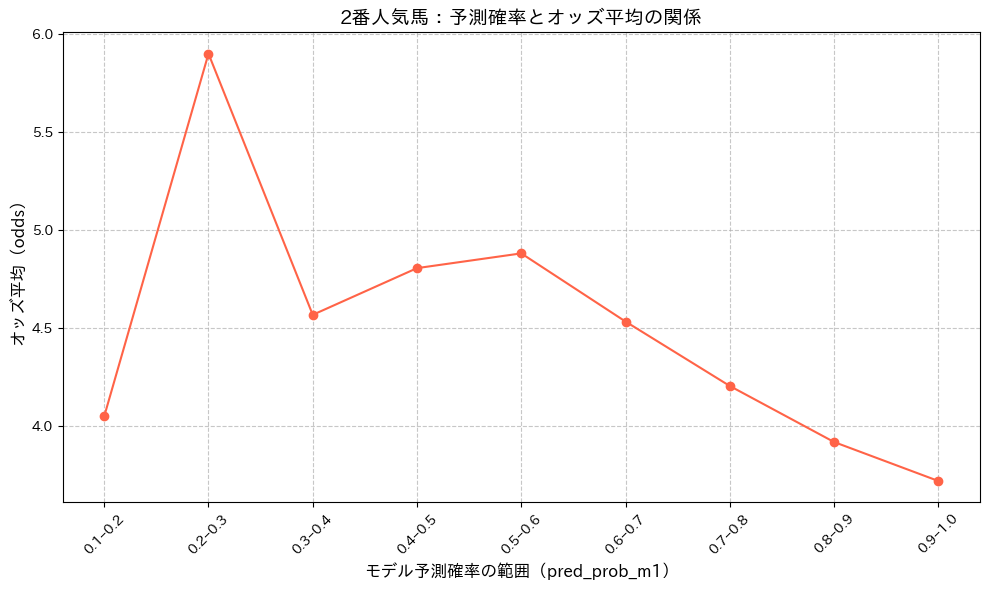

  prob_bin  „Çµ„É≥„Éó„É´Êï∞     „Ç™„ÉÉ„Ç∫Âπ≥Âùá
0  0.0‚Äì0.1      0       NaN
1  0.1‚Äì0.2      8  4.050000
2  0.2‚Äì0.3     18  5.900000
3  0.3‚Äì0.4     34  4.567647
4  0.4‚Äì0.5    102  4.805882
5  0.5‚Äì0.6    239  4.881172
6  0.6‚Äì0.7    402  4.533333
7  0.7‚Äì0.8    492  4.204675
8  0.8‚Äì0.9    320  3.918750
9  0.9‚Äì1.0     30  3.720000


In [41]:
# ‚ñº „Éë„É©„É°„Éº„ÇøÔºà‰ªªÊÑè„ÅÆ‰∫∫Ê∞ó„ÇíÊåáÂÆöÔºâ
target_popularity = 2

# ‚ñº 1. ÊåáÂÆö‰∫∫Ê∞ó„Å†„ÅëÊäΩÂá∫
df_fixed_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº 2. „É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„Åß„Éì„É≥ÂàÜ„ÅëÔºà0.0„Äú1.0 „Çí 0.1Âàª„ÅøÔºâ
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}‚Äì{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_fixed_pop['prob_bin'] = pd.cut(df_fixed_pop['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# ‚ñº 3. ÂêÑ„Éì„É≥„Åî„Å®„ÅÆ„Ç™„ÉÉ„Ç∫Âπ≥Âùá„ÇíË®àÁÆó
odds_stats = (
    df_fixed_pop.groupby('prob_bin')
    .agg(
        „Çµ„É≥„Éó„É´Êï∞=('odds', 'count'),
        „Ç™„ÉÉ„Ç∫Âπ≥Âùá=('odds', 'mean')
    )
    .reset_index()
)

# ‚ñº 4. „Ç∞„É©„ÉïË°®Á§∫
plt.figure(figsize=(10, 6))
plt.plot(odds_stats['prob_bin'], odds_stats['„Ç™„ÉÉ„Ç∫Âπ≥Âùá'], marker='o', linestyle='-', color='tomato')
plt.xlabel('„É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„ÅÆÁØÑÂõ≤Ôºàpred_prob_m1Ôºâ', fontsize=12)
plt.ylabel('„Ç™„ÉÉ„Ç∫Âπ≥ÂùáÔºàoddsÔºâ', fontsize=12)
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞óÈ¶¨Ôºö‰∫àÊ∏¨Á¢∫Áéá„Å®„Ç™„ÉÉ„Ç∫Âπ≥Âùá„ÅÆÈñ¢‰øÇ', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ‚ñº Ë°®„ÅÆÂá∫ÂäõÔºàÁ¢∫Ë™çÁî®Ôºâ
print(odds_stats)

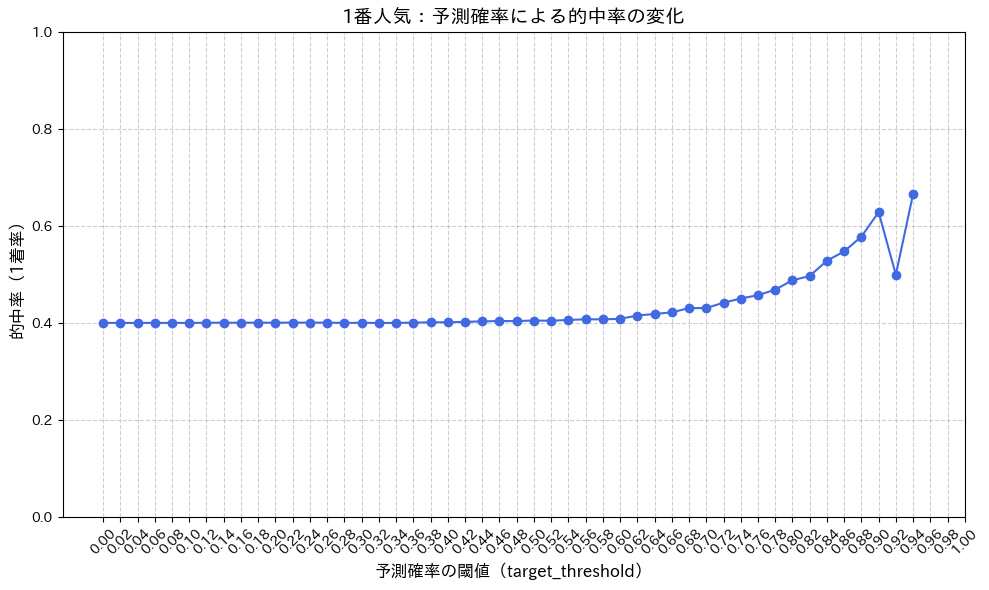

In [343]:
import numpy as np
import matplotlib.pyplot as plt

# ‚ñº ÊåáÂÆö„Åô„Çã‰∫∫Ê∞ó
target_popularity = 1

# ‚ñº „Éá„Éº„Çø„ÅÆ„Éï„Ç£„É´„ÇøÔºöÊåáÂÆö‰∫∫Ê∞ó„ÅÆÈ¶¨„Å†„Åë
df_target_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº ÈñæÂÄ§„ÅÆÁØÑÂõ≤Ôºà0.0„Äú1.0 „Çí 0.05Âàª„Åø„ÅßÔºâ
thresholds = np.arange(0.0, 1.01, 0.02)

hit_rates = []  # ÁöÑ‰∏≠Áéá„É™„Çπ„Éà

for thresh in thresholds:
    df_thresh = df_target_pop[df_target_pop['pred_prob_m1'] >= thresh]
    total = len(df_thresh)
    if total == 0:
        hit_rate = np.nan  # „Éá„Éº„Çø„Å™„Åó„ÅÆÂ†¥Âêà„ÅØNaN
    else:
        hits = (df_thresh['finish_rank'] == 1).sum()
        hit_rate = hits / total
    hit_rates.append(hit_rate)

# ‚ñº „Ç∞„É©„Éï„ÅÆÊèèÁîª
plt.figure(figsize=(10, 6))
plt.plot(thresholds, hit_rates, marker='o', linestyle='-', color='royalblue')
plt.xlabel('‰∫àÊ∏¨Á¢∫Áéá„ÅÆÈñæÂÄ§Ôºàtarget_thresholdÔºâ', fontsize=12)
plt.ylabel('ÁöÑ‰∏≠ÁéáÔºà1ÁùÄÁéáÔºâ', fontsize=12)
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞óÔºö‰∫àÊ∏¨Á¢∫Áéá„Å´„Çà„ÇãÁöÑ‰∏≠Áéá„ÅÆÂ§âÂåñ', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.round(thresholds, 2), rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


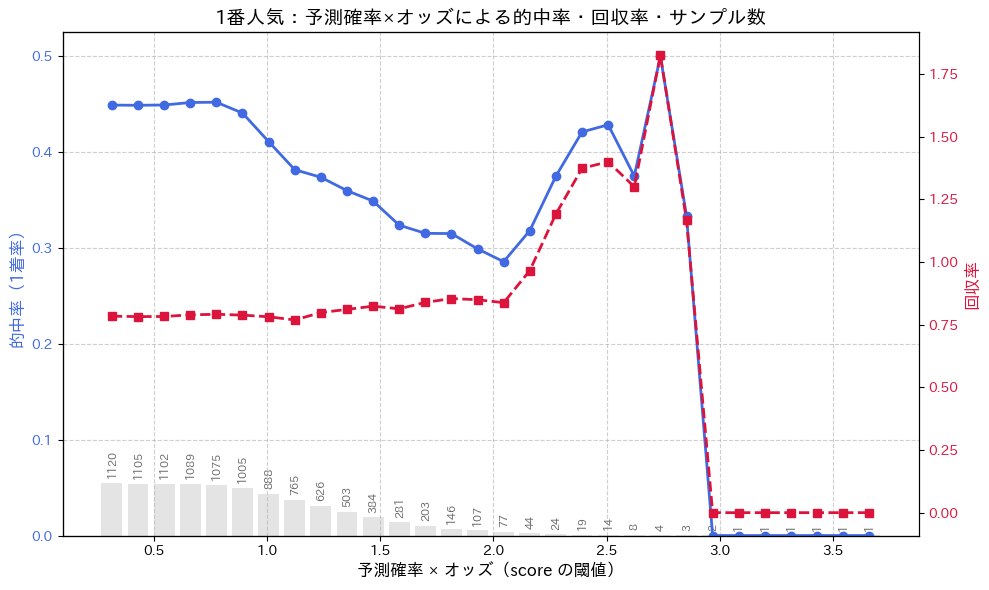

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Ë®≠ÂÆö
# =============================
target_popularity = 1  # ÂØæË±°‰∫∫Ê∞ó
df_target_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# „Çπ„Ç≥„Ç¢Ôºà‰∫àÊ∏¨Á¢∫Áéá √ó „Ç™„ÉÉ„Ç∫Ôºâ
df_target_pop['score'] = df_target_pop['pred_prob_m1'] * df_target_pop['odds']

# ÈñæÂÄ§ÁØÑÂõ≤Ôºà„Çπ„Ç≥„Ç¢„Å´Âøú„Åò„Å¶Ôºâ
min_score = df_target_pop['score'].min()
max_score = df_target_pop['score'].max()
thresholds = np.linspace(min_score, max_score, 30)

hit_rates = []
rois = []
sample_sizes = []

for thresh in thresholds:
    df_thresh = df_target_pop[df_target_pop['score'] >= thresh]
    n = len(df_thresh)
    sample_sizes.append(n)

    if n == 0:
        hit_rates.append(np.nan)
        rois.append(np.nan)
        continue

    hit_count = (df_thresh['finish_rank'] == 1).sum()
    hit_rate = hit_count / n
    return_sum = df_thresh.loc[df_thresh['finish_rank'] == 1, 'odds'].sum()
    roi = return_sum / n

    hit_rates.append(hit_rate)
    rois.append(roi)

# =============================
# „Ç∞„É©„ÉïÊèèÁîª
# =============================
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Êäò„ÇåÁ∑öÔºàÁöÑ‰∏≠ÁéáÔºâ ---
color1 = 'royalblue'
ax1.plot(thresholds, hit_rates, marker='o', color=color1, label='ÁöÑ‰∏≠Áéá', linewidth=2, zorder=5)
ax1.set_xlabel('‰∫àÊ∏¨Á¢∫Áéá √ó „Ç™„ÉÉ„Ç∫Ôºàscore „ÅÆÈñæÂÄ§Ôºâ', fontsize=12)
ax1.set_ylabel('ÁöÑ‰∏≠ÁéáÔºà1ÁùÄÁéáÔºâ', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.6, zorder=0)

# --- Âè≥Ëª∏ÔºàÂõûÂèéÁéáÔºâ ---
ax2 = ax1.twinx()
color2 = 'crimson'
ax2.plot(thresholds, rois, marker='s', linestyle='--', color=color2, label='ÂõûÂèéÁéá', linewidth=2, zorder=6)
ax2.set_ylabel('ÂõûÂèéÁéá', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

# --- „Çµ„É≥„Éó„É´Êï∞„Éê„ÉºÔºàÂà•„Çπ„Ç±„Éº„É´„Åß‰∏ãÈÉ®„Å´Ë°®Á§∫Ôºâ ---
ax3 = ax1.twinx()  # „Åï„Çâ„Å´Á¨¨3Ëª∏„ÇíÈáç„Å≠„Çã
ax3.spines['right'].set_position(('outward', 60))  # Â∞ë„ÅóÂè≥„Å´„Åö„Çâ„Åô
ax3.set_yticks([])  # ÁõÆÁõõ„Çä„ÅØÈùûË°®Á§∫

bar_color = 'lightgray'
bar_width = (thresholds[1] - thresholds[0]) * 0.8
bar_bottom = ax1.get_ylim()[0] - 0.05  # „Ç∞„É©„Éï‰∏ã„Å´ÈÖçÁΩÆ

# Ê≠£Ë¶èÂåñ„Åó„Å¶‰∏ã„Å´ËñÑ„ÅèÂá∫„ÅôÔºàÈ´ò„Åï0„Äú0.1Á®ãÂ∫¶Ôºâ
max_bar_height = (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.1
bar_heights = (np.array(sample_sizes) / max(sample_sizes)) * max_bar_height

# Ê£í„ÇíÊèèÁîª
ax1.bar(thresholds, bar_heights, width=bar_width, color=bar_color, alpha=0.6, zorder=1)

# Ê£í„ÅÆ‰∏ä„Å´„Çµ„É≥„Éó„É´Êï∞„ÅÆÊï∞Â≠ó„ÇíÊèèÁîª
for x, h, n in zip(thresholds, bar_heights, sample_sizes):
    ax1.text(x, h + ax1.get_ylim()[0] + 0.005, str(n),
             ha='center', va='bottom', fontsize=8, color='dimgray', rotation=90)

# --- „Çø„Ç§„Éà„É´„Å™„Å© ---
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞óÔºö‰∫àÊ∏¨Á¢∫Áéá√ó„Ç™„ÉÉ„Ç∫„Å´„Çà„ÇãÁöÑ‰∏≠Áéá„ÉªÂõûÂèéÁéá„Éª„Çµ„É≥„Éó„É´Êï∞', fontsize=14)
plt.tight_layout()
plt.show()


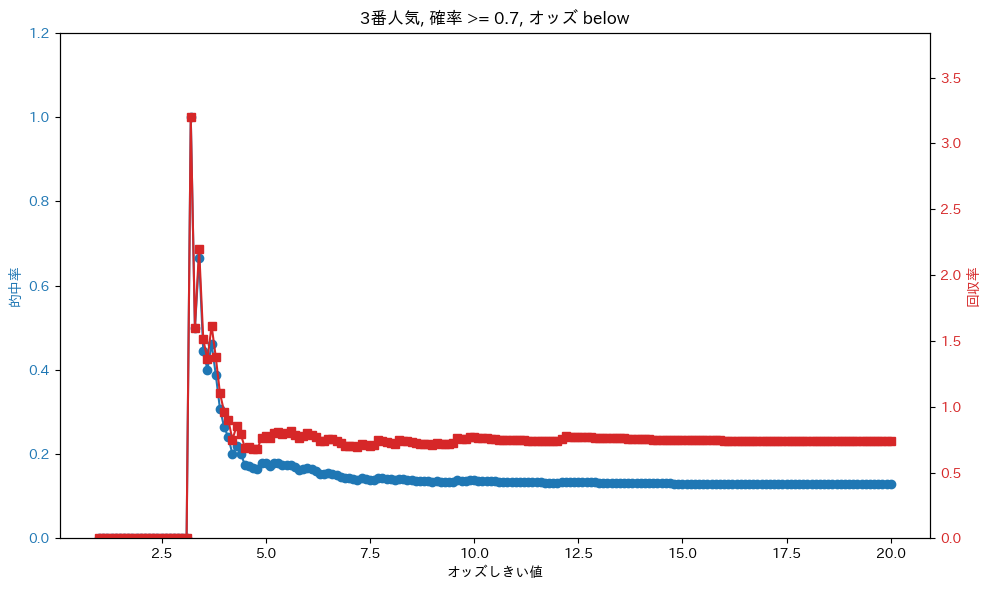

In [121]:
# ‚ñº „Éë„É©„É°„Éº„ÇøË®≠ÂÆö
target_popularity = 3
prob_threshold = 0.7
odds_min = 1.0
odds_max = 20
odds_step = 0.1
filter_type = 'below'  # 'below' or 'above'

# ‚ñº Ë©≤ÂΩì‰∫∫Ê∞ó„Å†„Åë„Å´Áµû„Çã
df_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ‚ñº „É¢„Éá„É´‰∫àÊ∏¨Á¢∫Áéá„ÅåÈ´ò„ÅÑÈ¶¨„ÇíÊäΩÂá∫
df_high_prob = df_pop[df_pop['pred_prob_m1'] >= prob_threshold].copy()

# ‚ñº ÁµêÊûúË®òÈå≤„É™„Çπ„Éà
odds_thresholds = []
hit_rates = []
rois = []
sample_sizes = []

# ‚ñº „Ç™„ÉÉ„Ç∫„Åó„Åç„ÅÑÂÄ§„ÇíÂ§âÂåñ„Åï„Åõ„Å™„Åå„ÇâÈõÜË®à
odds_range = np.arange(odds_min, odds_max + odds_step, odds_step)

for threshold in odds_range:
    if filter_type == 'below':
        subset = df_high_prob[df_high_prob['odds'] <= threshold].copy()
    elif filter_type == 'above':
        subset = df_high_prob[df_high_prob['odds'] > threshold].copy()
    else:
        raise ValueError("filter_type „ÅØ 'below' „Åæ„Åü„ÅØ 'above' „Å´„Åó„Å¶„Åè„Å†„Åï„ÅÑ")

    sample_size = len(subset)
    hit_count = (subset['finish_rank'] == 1).sum()
    return_sum = subset.loc[subset['finish_rank'] == 1, 'odds'].sum()

    hit_rate = hit_count / sample_size if sample_size > 0 else 0
    roi = return_sum / sample_size if sample_size > 0 else 0

    # ÁµêÊûúË®òÈå≤
    odds_thresholds.append(threshold)
    hit_rates.append(hit_rate)
    rois.append(roi)
    sample_sizes.append(sample_size)

# ‚ñº „Ç∞„É©„ÉïË°®Á§∫ÔºàÁöÑ‰∏≠Áéá & ÂõûÂèéÁéá„ÅÆ2Ëª∏Ôºâ
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('„Ç™„ÉÉ„Ç∫„Åó„Åç„ÅÑÂÄ§')
ax1.set_ylabel('ÁöÑ‰∏≠Áéá', color=color1)
ax1.plot(odds_thresholds, hit_rates, color=color1, label='ÁöÑ‰∏≠Áéá', marker='o')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, max(hit_rates) * 1.2)

# ‚ñº ÂõûÂèéÁéá„ÅÆËª∏
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('ÂõûÂèéÁéá', color=color2)
ax2.plot(odds_thresholds, rois, color=color2, label='ÂõûÂèéÁéá', marker='s')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(rois) * 1.2)

# ‚ñº „Çø„Ç§„Éà„É´„ÉªÂá°‰æã
plt.title(f'{target_popularity}Áï™‰∫∫Ê∞ó, Á¢∫Áéá >= {prob_threshold}, „Ç™„ÉÉ„Ç∫ {filter_type}')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig("C:\\Users\\ryo\\Downloads\\plot.png")
plt.show()


C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layo

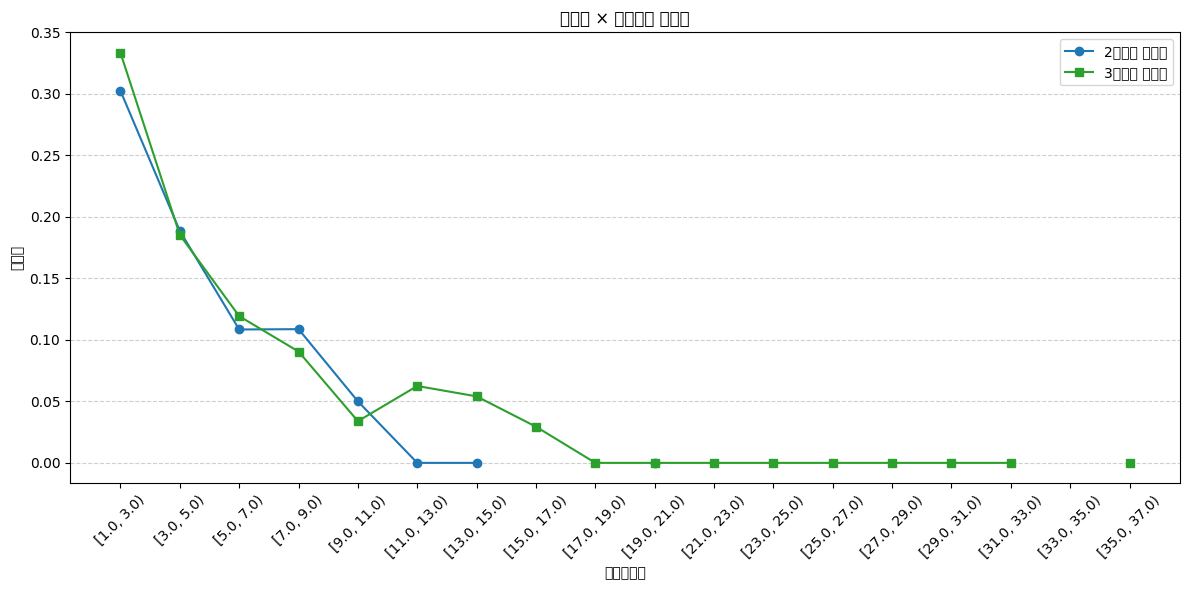

C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missin

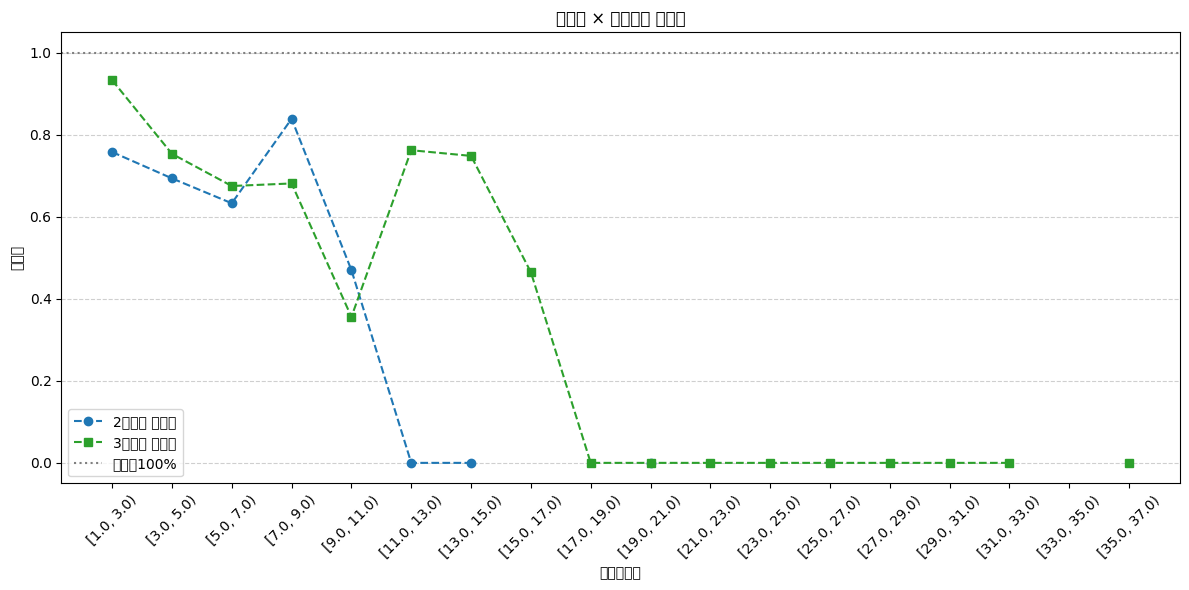

In [39]:

# -------- „Éë„É©„É°„Éº„Çø --------
odds_bins = np.arange(1.0, 51.0, 2.0)  # „Ç™„ÉÉ„Ç∫„Çí2Âàª„Åø„ÅßÂàÜÂâ≤
target_popularities = [2, 3]           # ÊØîËºÉ„Åó„Åü„ÅÑ‰∫∫Ê∞ó

# -------- „Éá„Éº„ÇøÂèéÈõÜ --------
plot_data = {}

for pop in target_popularities:
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    if df_pop.empty:
        continue

    df_pop['odds_bin'] = pd.cut(df_pop['odds'], bins=odds_bins, right=False)
    df_pop['hit'] = (df_pop['finish_rank'] == 1).astype(int)
    df_pop['return'] = df_pop['odds'] * df_pop['hit']

    stats = (
        df_pop.groupby('odds_bin')
        .agg(
            sample_size=('hit', 'count'),
            hit_count=('hit', 'sum'),
            return_sum=('return', 'sum')
        )
        .reset_index()
    )

    stats['hit_rate'] = stats['hit_count'] / stats['sample_size']
    stats['roi'] = stats['return_sum'] / stats['sample_size']
    stats['odds_bin_str'] = stats['odds_bin'].astype(str)
    plot_data[pop] = stats

# -------- ÂÖ±ÈÄöË®≠ÂÆö --------
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple']
markers = ['o', 's', 'D', '^', 'v']

# -------- „Ç∞„É©„Éï‚ë†ÔºöÁöÑ‰∏≠Áéá --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['hit_rate'],
             label=f'{pop}Áï™‰∫∫Ê∞ó ÁöÑ‰∏≠Áéá',
             color=colors[i % len(colors)], marker=markers[i % len(markers)])

plt.xlabel('„Ç™„ÉÉ„Ç∫ÁØÑÂõ≤')
plt.ylabel('ÁöÑ‰∏≠Áéá')
plt.title('‰∫∫Ê∞óÂà• √ó „Ç™„ÉÉ„Ç∫Âà• ÁöÑ‰∏≠Áéá')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------- „Ç∞„É©„Éï‚ë°ÔºöÂõûÂèéÁéá --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['roi'],
             label=f'{pop}Áï™‰∫∫Ê∞ó ÂõûÂèéÁéá',
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--')

plt.xlabel('„Ç™„ÉÉ„Ç∫ÁØÑÂõ≤')
plt.ylabel('ÂõûÂèéÁéá')
plt.title('‰∫∫Ê∞óÂà• √ó „Ç™„ÉÉ„Ç∫Âà• ÂõûÂèéÁéá')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='gray', linestyle='dotted', label='ÂõûÂèéÁéá100%')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:43:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ê≠£Á≠îÁéá (accuracy): 0.6608
Ê∑∑ÂêåË°åÂàó:
 [[ 17 114]
 [ 21 246]]
ÂàÜÈ°û„É¨„Éù„Éº„Éà:
               precision    recall  f1-score   support

           0       0.45      0.13      0.20       131
           1       0.68      0.92      0.78       267

    accuracy                           0.66       398
   macro avg       0.57      0.53      0.49       398
weighted avg       0.61      0.66      0.59       398


-------------------------


‚ñº Ë©ï‰æ°ÁµêÊûúÔºà3Áï™‰∫∫Ê∞óÔºâ
  ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞       : 398
  „É¢„Éá„É´„Åå1„Å®‰∫àÊ∏¨„Åó„ÅüÊï∞ : 360
  ÁöÑ‰∏≠Êï∞Ôºà1ÁùÄÔºâ         : 48
  Êâï„ÅÑÊàª„ÅóÂêàË®à           : 271.90
  ÂõûÂèéÁéá                 : 0.7553Ôºà75.53%Ôºâ
‚ñº Á¢∫Áéá„ÅßË≥ºÂÖ•Âà§Êñ≠Ôºà„Åó„Åç„ÅÑÂÄ§ = 0.7 Ôºâ
ÂØæË±°‰∫∫Ê∞ó           : 3Áï™‰∫∫Ê∞ó
ÂÖ®‰Ωì„É¨„Éº„ÇπÊï∞       : 398
Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞   : 42
ÁöÑ‰∏≠Êï∞             : 12
ÁöÑ‰∏≠Áéá             : 0.2857Ôºà28.57%Ôºâ
ÂõûÂèéÁéá             : 1.1595Ôºà115.95%Ôºâ
          feature  importance
2  pop3_pred_prob    2.988739

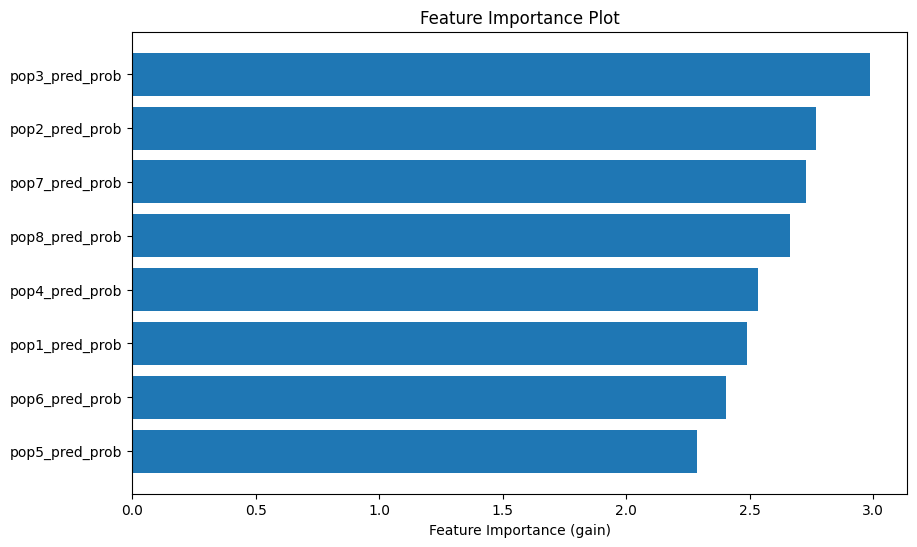

In [205]:
# 1. ‰∫∫Ê∞ó„ÅåÈáçË§á„Åó„Å¶„ÅÑ„Çã„É¨„Éº„ÇπID„ÇíÁâπÂÆö
pop_counts = full_pred_df.groupby(['race_id', 'popularity']).size().reset_index(name='count')
duplicated_pops = pop_counts[pop_counts['count'] > 1]['race_id'].unique()

# 2. full_pred_df „Åã„ÇâÈô§Â§ñÔºàÈáçË§á‰∫∫Ê∞ó„ÇíÂê´„ÇÄ„É¨„Éº„Çπ„ÅØÂÖ®Èô§Â§ñÔºâ
clean_df = full_pred_df[~full_pred_df['race_id'].isin(duplicated_pops)].copy()

# 3. ‰∫∫Ê∞ó„Åî„Å®„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÇíÊ®™ÊåÅ„Å°„Å´„Åô„ÇãÔºàpivotÔºâ
feature_df = clean_df.copy()
feature_df['pop_col'] = feature_df['popularity'].apply(lambda x: f'pop{x}_pred_prob')
X_all = feature_df.pivot(index='race_id', columns='pop_col', values='pred_prob_m1').reset_index()

# 4. „Çø„Éº„Ç≤„ÉÉ„Éà‰∫∫Ê∞ó„ÅÆÁõÆÁöÑÂ§âÊï∞‰ΩúÊàêÔºà‰æãÔºö3Áï™‰∫∫Ê∞ó„Åå1ÁùÄ„Åã„Å©„ÅÜ„ÅãÔºâ
target_popularity = 3
y_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'finish_rank']].copy()
y_df['target'] = (y_df['finish_rank'] <= 4).astype(int)

# 5. Â≠¶ÁøíÁî®„Å´„Éû„Éº„Ç∏
data = pd.merge(X_all, y_df[['race_id', 'target']], on='race_id', how='inner')

# 6. ÁâπÂæ¥Èáè„ÉªÁõÆÁöÑÂ§âÊï∞„Å´ÂàÜÂâ≤
X = data.drop(columns=['race_id', 'target'])
y = data['target']

# 7. „É¢„Éá„É´Â≠¶ÁøíÔºà‰æãÔºöXGBoostÔºâ
from sklearn.model_selection import train_test_split
import xgboost as xgb

# race_id „ÅÆÂÖàÈ†≠2Ê°Å„Åã„Çâ„ÄåÂπ¥„Äç„ÇíÊäΩÂá∫ÔºàÊñáÂ≠óÂàó„Å®„Åó„Å¶Âá¶ÁêÜÔºâ
data['year'] = data['race_id'].astype(str).str[:2]

# Â≠¶Áøí„Éá„Éº„ÇøÔºö2023Âπ¥Ôºà= '23'Ôºâ
train_data = data[data['year'] == '23']
X_train = train_data.drop(columns=['race_id', 'target', 'year'])
y_train = train_data['target']

# Ê§úË®º„Éá„Éº„ÇøÔºö2024Âπ¥Ôºà= '24'Ôºâ
val_data = data[data['year'] == '24']
X_val = val_data.drop(columns=['race_id', 'target', 'year'])
y_val = val_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ====== „Éë„É©„É°„Éº„ÇøÂÆöÁæ© ======
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

# ====== „É¢„Éá„É´ÂÆöÁæ© ======
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)

# 8. Ë©ï‰æ°
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_val)

# „É¢„Éá„É´‰∫àÊ∏¨
y_pred = model.predict(X_val)

# X_val „Å´ race_id „Çí‰ªò‰∏éÔºàÂÖÉ„ÅÆ„Éá„Éº„Çø„Åã„ÇâÂèñÂæóÔºâ
X_val_with_preds = X_val.copy()
X_val_with_preds['race_id'] = data.loc[X_val.index, 'race_id'].values
X_val_with_preds['y_true'] = y_val.values
X_val_with_preds['y_pred'] = y_pred

# race_id Âçò‰Ωç„ÅßÈáçË§á„ÇíÈô§„ÅèÔºà1‰∫∫Ê∞ó„ÅÇ„Åü„Çä1Ë°åÔºâ
target_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'odds', 'finish_rank', 'popularity']].copy()

# ‰∫àÊ∏¨ÁµêÊûú„Å®Áµ±Âêà
eval_df = pd.merge(X_val_with_preds, target_df, on='race_id', how='left')

# ‚úÖ ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞ÔºàÈáçË§áÈô§„ÅÑ„Å¶„Ç´„Ç¶„É≥„ÉàÔºâ
total_races = eval_df['race_id'].nunique()

# ‚úÖ ‰∫àÊ∏¨„Åå1Ôºà=Ë≥ºÂÖ•ÂØæË±°Ôºâ„ÅÆ„É¨„Éº„Çπ„Å†„ÅëÊäΩÂá∫
bets = eval_df[eval_df['y_pred'] == 1].copy()
bets['hit'] = (bets['finish_rank'] == 1).astype(int)  # ÁöÑ‰∏≠ = 1ÁùÄ

# Ë≥ºÂÖ•Êï∞„ÄÅÁöÑ‰∏≠Êï∞„ÄÅÊâï„ÅÑÊàª„ÅóÂêàË®à
num_bets = len(bets)
num_hits = bets['hit'].sum()
total_return = (bets['odds'] * bets['hit']).sum()
roi = total_return / num_bets if num_bets > 0 else 0
# Ë©ï‰æ°ÊåáÊ®ô
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Ê≠£Á≠îÁéá (accuracy): {acc:.4f}")
print("Ê∑∑ÂêåË°åÂàó:\n", cm)
print("ÂàÜÈ°û„É¨„Éù„Éº„Éà:\n", report)
print("\n-------------------------\n")
# ‚úÖ Âá∫Âäõ
print(f"\n‚ñº Ë©ï‰æ°ÁµêÊûúÔºà{target_popularity}Áï™‰∫∫Ê∞óÔºâ")
print(f"  ÂÖ®‰Ωì„ÅÆ„É¨„Éº„ÇπÊï∞       : {total_races}")
print(f"  „É¢„Éá„É´„Åå1„Å®‰∫àÊ∏¨„Åó„ÅüÊï∞ : {num_bets}")
print(f"  ÁöÑ‰∏≠Êï∞Ôºà1ÁùÄÔºâ         : {num_hits}")
print(f"  Êâï„ÅÑÊàª„ÅóÂêàË®à           : {total_return:.2f}")
print(f"  ÂõûÂèéÁéá                 : {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ====== „Éë„É©„É°„Éº„ÇøË®≠ÂÆö ======
prob_threshold = 0.7      # Ë≥ºÂÖ•„Åô„ÇãÁ¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà‰æãÔºö0.7Ôºâ
odds_threshold = 4.5      # Ë≥ºÂÖ•„Åô„Çã„Ç™„ÉÉ„Ç∫„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà‰æãÔºö3.0Ôºâ

# ====== ‰∫àÊ∏¨Á¢∫Áéá„ÅÆÂèñÂæó ======
y_proba = model.predict_proba(X_val)[:, 1]  # „ÇØ„É©„Çπ1Ôºà1ÁùÄ„Å´„Å™„ÇãÁ¢∫ÁéáÔºâ„ÅÆ„Åø

# ====== „Éá„Éº„ÇøÁµêÂêà ======
# X_val „Å´„ÅØ race_id „Å™„Å©„ÅÆÊÉÖÂ†±„Åå„Å™„ÅÑ„ÅÆ„Åß„ÄÅfeature_df „Åã„Çâ race_id, odds, finish_rank „ÇíÂèñÂæó
val_df_with_info = eval_df[eval_df['popularity'] == target_popularity].copy()
val_df_with_info = val_df_with_info.reset_index(drop=True)  # Âøµ„ÅÆ„Åü„ÇÅÊï¥Âàó

val_df_with_info['pred_prob'] = y_proba
val_df_with_info['hit'] = (val_df_with_info['finish_rank'] == 1).astype(int)

# ====== Ë≥ºÂÖ•„Åô„Çã„É¨„Éº„ÇπÔºàÁ¢∫Áéá„ÅåÈ´ò„ÅÑ„ÇÇ„ÅÆÔºâ ======
bets = val_df_with_info[
    (val_df_with_info['pred_prob'] >= prob_threshold) &
    (val_df_with_info['odds'] <= odds_threshold)
].copy()

# ====== ÂõûÂèéÁéá„ÉªÁöÑ‰∏≠ÁéáË®àÁÆó ======
race_count_total = len(val_df_with_info)
race_count_bet = len(bets)
hit_count = bets['hit'].sum()
hit_rate = hit_count / race_count_bet if race_count_bet > 0 else 0
total_return = bets.loc[bets['hit'] == 1, 'odds'].sum()
roi = total_return / race_count_bet if race_count_bet > 0 else 0

# ====== ÁµêÊûúË°®Á§∫ ======
print("‚ñº Á¢∫Áéá„ÅßË≥ºÂÖ•Âà§Êñ≠Ôºà„Åó„Åç„ÅÑÂÄ§ =", prob_threshold, "Ôºâ")
print(f"ÂØæË±°‰∫∫Ê∞ó           : {target_popularity}Áï™‰∫∫Ê∞ó")
print(f"ÂÖ®‰Ωì„É¨„Éº„ÇπÊï∞       : {race_count_total}")
print(f"Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞   : {race_count_bet}")
print(f"ÁöÑ‰∏≠Êï∞             : {hit_count}")
print(f"ÁöÑ‰∏≠Áéá             : {hit_rate:.4f}Ôºà{hit_rate:.2%}Ôºâ")
print(f"ÂõûÂèéÁéá             : {roi:.4f}Ôºà{roi:.2%}Ôºâ")

# ====== „Ç™„Éó„Ç∑„Éß„É≥ÔºöCSVÂá∫Âäõ ======
bets.to_csv(f'pop{target_popularity}_prob{prob_threshold}_bets.csv', index=False, encoding='cp932')

import matplotlib.pyplot as plt
import xgboost as xgb

# 1. ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶„ÅÆÂèñÂæóÔºàgain, weight, cover „Å™„Å©„ÅÑ„Çç„ÅÑ„Çç„ÅÇ„Çä„Åæ„Åô„Åå„ÄÅ'gain'„Åå„Çà„Åè‰Ωø„Çè„Çå„Åæ„ÅôÔºâ
importance = model.get_booster().get_score(importance_type='gain')

# 2. ËæûÊõ∏ ‚Üí DataFrame „Å´Â§âÊèõ„Åó„Å¶Ë¶ã„ÇÑ„Åô„Åè
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

# 3. Ê£í„Ç∞„É©„Éï„ÅßÂèØË¶ñÂåñ
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()  # ÈáçË¶ÅÂ∫¶„ÅÆÈ´ò„ÅÑÈ†Ü„Å´Ë°®Á§∫
plt.xlabel('Feature Importance (gain)')
plt.title('Feature Importance Plot')
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

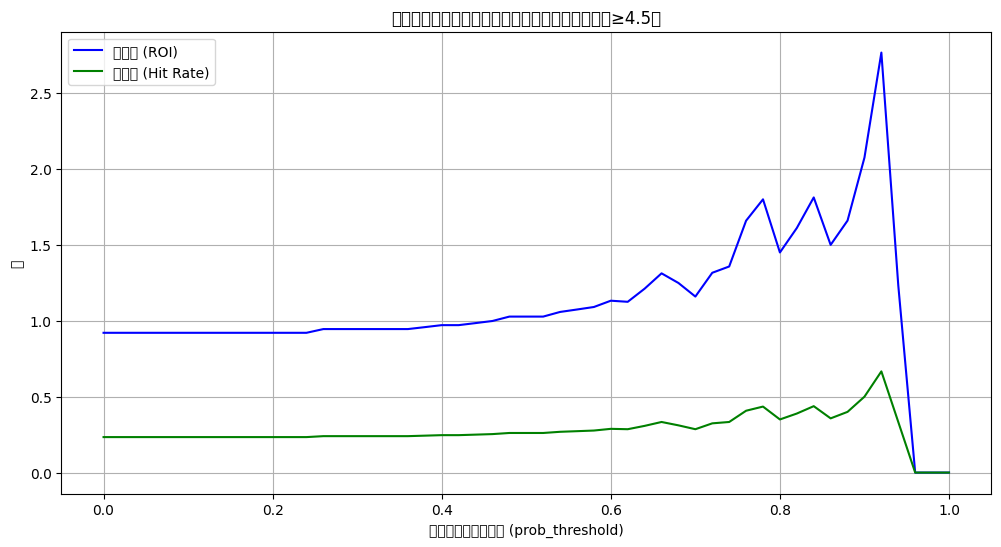

C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35937 (\N{CJK UNIFIED IDEOGRAPH-8C61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canva

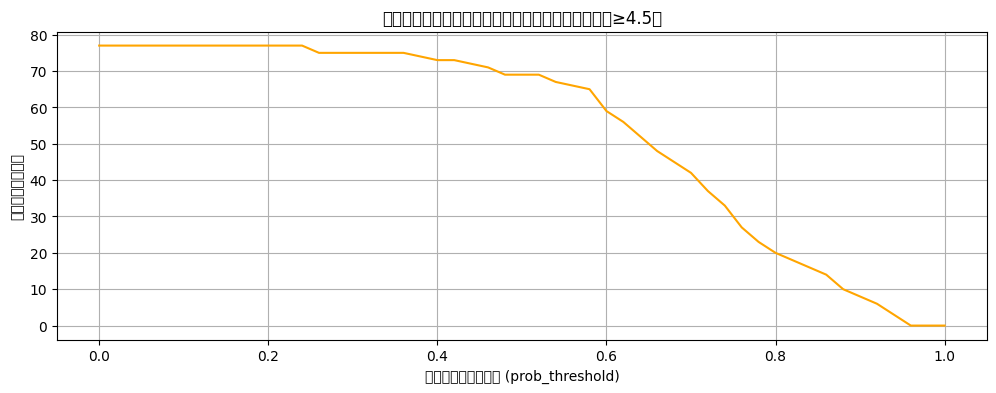

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§Ôºà0„Äú1Ôºâ
thresholds = np.arange(0.0, 1.01, 0.02)

roi_list = []
hit_rate_list = []
bet_count_list = []

for thr in thresholds:
    # Á¢∫Áéá„Å®„Ç™„ÉÉ„Ç∫‰∏°Êñπ„ÅÆÊù°‰ª∂„ÅßË≥ºÂÖ•Âà§Êñ≠
    bets_thr = val_df_with_info[
        (val_df_with_info['pred_prob'] >= thr) &
        (val_df_with_info['odds'] <= odds_threshold)
    ].copy()
    
    num_bets = len(bets_thr)
    if num_bets > 0:
        hits = bets_thr['hit'].sum()
        hit_rate = hits / num_bets
        total_return = bets_thr.loc[bets_thr['hit'] == 1, 'odds'].sum()
        roi = total_return / num_bets
    else:
        hit_rate = 0
        roi = 0
    
    roi_list.append(roi)
    hit_rate_list.append(hit_rate)
    bet_count_list.append(num_bets)

# „Ç∞„É©„ÉïÊèèÁîª
plt.figure(figsize=(12,6))
plt.plot(thresholds, roi_list, label='ÂõûÂèéÁéá (ROI)', color='blue')
plt.plot(thresholds, hit_rate_list, label='ÁöÑ‰∏≠Áéá (Hit Rate)', color='green')
plt.xlabel('Ë≥ºÂÖ•Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§ (prob_threshold)')
plt.ylabel('Áéá')
plt.title(f'Ë≥ºÂÖ•Á¢∫Áéá„Åó„Åç„ÅÑÂÄ§„Åî„Å®„ÅÆÂõûÂèéÁéá„Å®ÁöÑ‰∏≠ÁéáÔºà„Ç™„ÉÉ„Ç∫‚â•{odds_threshold}Ôºâ')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(thresholds, bet_count_list, label='Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞', color='orange')
plt.xlabel('Ë≥ºÂÖ•Á¢∫Áéá„ÅÆ„Åó„Åç„ÅÑÂÄ§ (prob_threshold)')
plt.ylabel('Ë≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞')
plt.title(f'Ë≥ºÂÖ•Á¢∫Áéá„Åó„Åç„ÅÑÂÄ§„Åî„Å®„ÅÆË≥ºÂÖ•ÂØæË±°„É¨„Éº„ÇπÊï∞Ôºà„Ç™„ÉÉ„Ç∫‚â•{odds_threshold}Ôºâ')
plt.grid(True)
plt.show()
